<a href="https://colab.research.google.com/github/sumkh/ITI110_AgenticRAG/blob/main/AgenticRag_Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AI Tutor Chatbot (Version 2.4)

### Setup - Local Computer

##### Prerequisites

- Python 3.9+ installed
- pip (Python package installer)

##### Environment Setup

To set up and activate a virtual environment:

1. **Clone the repository:**

   ```bash
   git clone https://github.com/sumkh/ITI110_AgenticRAG.git
   cd ITI110_AgenticRAG
   ```

   Use `cd` to move into the project directory where you want to create your environment (e.g., cd my_project)

2. **Create a virtual environment:**

   ```bash
   python3 -m venv yourenv
   ```

   Replace "env" with the name you want for your environment, like `yourenv`. This creates a folder named `yourenv` (or your chosen name) in your project directory.

3. **Activate the virtual environment:**

   ```bash
   source yourenv/bin/activate
   ```

   Replace `yourenv` if you used a different name.

4. **Install dependencies:**

   ```bash
   pip install -r requirements.txt
   ```

### Setup - Google Colab (Please RE-START SESSION after pip install packages)

In [2]:
%%capture
# Download required files from Github repo
!wget https://github.com/sumkh/NYP_Dataset/raw/refs/heads/main/Documents.zip
!unzip /content/Documents.zip


In [3]:
%%capture
%pip install vllm langchain-groq huggingface_hub transformers langchain langchain_huggingface langgraph accelerate bitsandbytes langchain-core langchain-text-splitters langchain-community chromadb langchain-chroma langsmith docling langchain-docling sentence_transformers

- Reference: https://ai.gopubby.com/building-rag-research-multi-agent-with-langgraph-1bd47acac69f
- Reference: https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/

## DEVELOPMENT & EXPERIMENTATION STAGE

In [ ]:
import os
import csv
import json
import hashlib
import uuid
import logging
from typing import List, Optional, Union, Literal, Dict
from dataclasses import dataclass, field

# LangChain & related imports
from langchain_core.tools import tool, StructuredTool
from pydantic import BaseModel, Field

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import EnsembleRetriever, ContextualCompressionRetriever

# Extraction for Documents
from langchain_docling.loader import ExportType
from langchain_docling import DoclingLoader
from docling.chunking import HybridChunker

# Extraction for HTML
from langchain_community.document_loaders import WebBaseLoader
from urllib.parse import urlparse


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


from google.colab import userdata
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Disable tokenizers parallelism, as it causes issues with multiprocessing
os.environ["LANGCHAIN_TRACING_V2"] = "true" # LangSmith for Observability
os.environ["LANGCHAIN_PROJECT"] = "AgenticRAG"
os.environ["LANGSMITH_API_KEY"] = userdata.get("LANGSMITH_API_KEY")

from huggingface_hub import login
login(token=userdata.get("HF_AUTH_TOKEN"))

# Configurations and Get the API key from the environment variable
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"

### Development 1: Document Extraction Functions

**References**:
1. RAG with LangChain: https://ds4sd.github.io/docling/examples/rag_langchain/#setup
2. Automatic OCR language detection with tesseract: https://ds4sd.github.io/docling/examples/tesseract_lang_detection/
3. docling-langchain: https://github.com/DS4SD/docling-langchain

In [ ]:
# =============================================================================
#                         Document Extraction Functions
# =============================================================================

def extract_documents(doc_path: str) -> List[str]:
    """
    Recursively collects all file paths from folder 'doc_path'.
    Used by ExtractDocument.load_files() to find documents to parse.
    """
    extracted_docs = []å

    for root, _, files in os.walk(doc_path):
        for file in files:
            file_path = os.path.join(root, file)
            extracted_docs.append(file_path)
    return extracted_docs


def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))


def load_file(file_path: str) -> List[Document]:
    """
    Load a file from the given path and return a list of Document objects.
    """
    _documents = []

    # Load the file and extract the text chunks
    try:
        loader = DoclingLoader(
            file_path = file_path,
            export_type = ExportType.DOC_CHUNKS,
            chunker = HybridChunker(tokenizer=EMBED_MODEL_ID),
        )
        docs = loader.load()
        logger.info(f"Total parsed doc-chunks: {len(docs)} from Source: {file_path}")

        for d in docs:
            # Tag each document's chunk with the source file and a unique ID
            doc = Document(
                page_content=d.page_content,
                metadata={
                    "source": file_path,
                    "doc_id": _generate_uuid(d.page_content),
                    "source_type": "file",
                }
            )
            _documents.append(doc)
        logger.info(f"Total generated LangChain document chunks: {len(_documents)}\n.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents


# Define function to load documents from a folder
def load_files_from_folder(doc_path: str) -> List[Document]:
    """
    Load documents from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = extract_documents(doc_path)

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_file(file_path))

    return _documents

# =============================================================================
# Load structured data in csv file to LangChain Document format
def load_mcq_csvfiles(file_path: str) -> List[Document]:
    """
    Load structured data in mcq csv file from the given file path and return a list of Document object.
    Expected format: each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
    """
    _documents = []

    # iterate through each csv file and load each row into _dict_per_question format
    # Ensure we process only CSV files
    if not file_path.endswith(".csv"):
        return _documents  # Skip non-CSV files
    try:
        # Open and read the CSV file
        with open(file_path, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                # Ensure required columns exist in the row
                if not all(k in row for k in ["mcq_number", "mcq_type", "text_content"]): # Ensure required columns exist and exclude header
                    logger.error(f"Skipping row due to missing fields: {row}")
                    continue
                # Tag each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
                doc = Document(
                    page_content = row["text_content"], # text_content segment is separated by "|"
                    metadata={
                        "source": f"{file_path}_{row['mcq_number']}",  # file_path + mcq_number
                        "doc_id": _generate_uuid(f"{file_path}_{row['mcq_number']}"),  # Unique ID
                        "source_type": row["mcq_type"],  # MCQ type
                    }
                )
                _documents.append(doc)
            logger.info(f"Successfully loaded {len(_documents)} LangChain document chunks from {file_path}.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents

# Define function to load documents from a folder for structured data in csv file
def load_files_from_folder_mcq(doc_path: str) -> List[Document]:
    """
    Load mcq csv file from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = [
        os.path.join(doc_path, file) for file in os.listdir(doc_path)
        if file.endswith(".csv")  # Process only CSV files
    ]

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_mcq_csvfiles(file_path))

    return _documents

##### Usage: Loading Documents

Reference: https://ds4sd.github.io/docling/examples/rag_langchain/#document-loading

In [ ]:
# Load general documents from a folder
gen_doc_path = "./Documents/general"

docs = load_files_from_folder(gen_doc_path)

# Display some sample data
for i, doc in enumerate(docs[:1], start=1):
    print(f"[Document Chunk #{i}]")
    print(f"  Source: {doc.metadata.get('source')}")
    print(f"  Source Type: {doc.metadata.get('source_type')}")
    print(f"  Doc ID: {doc.metadata.get('doc_id')}")
    print(f"  Total chars: {len(doc.page_content)}")
    print(f"  Content (first 100 chars): {doc.page_content[:100]}...\n")

2025-02-07 00:07:59,512 - INFO - Going to convert document batch...
2025-02-07 00:07:59,513 - INFO - Processing document deeplearningreview.docx
2025-02-07 00:07:59,545 - INFO - Finished converting document deeplearningreview.docx in 0.04 sec.
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
2025-02-07 00:07:59,679 - INFO - Total parsed doc-chunks: 5 from Source: ./Documents/general/deeplearningreview.docx
2025-02-07 00:07:59,679 - INFO - Total generated LangChain document chunks: 5
.
2025-02-07 00:08:00,047 - INFO - Going to convert document batch...
2025-02-07 00:08:00,631 - INFO - Accelerator device: 'mps'
2025-02-07 00:08:03,423 - INFO - Accelerator device: 'mps'
2025-02-07 00:08:03,990 - INFO - Accelerator device: 'mps'
2025-02-07 00:08:04,444 - INFO - Processing document Topic 2 Create computer vision soultions with Azure AI vision.pdf
2025-02-07 00

[Document Chunk #1]
  Source: ./Documents/general/deeplearningreview.docx
  Source Type: file
  Doc ID: 214f7811-e59f-7cf0-8efe-a2d6987ff17a
  Total chars: 2720
  Content (first 100 chars): A Review of Deep Learning Techniques

Abstract: In today‚Äôs world, Deep learning techniques are pla...



In [ ]:
# Extracting mcq documents from the document folders
mcq_doc_path = "./Documents/mcq/"

mcq_docs = load_files_from_folder_mcq(mcq_doc_path)

# Display some sample data
for i, doc in enumerate(mcq_docs[:10], start=0):
    print(f"[Document Chunk #{i}]")
    print(f"  Source: {doc.metadata.get('source')}")
    print(f"  Source Type: {doc.metadata.get('source_type')}")
    print(f"  Doc ID: {doc.metadata.get('doc_id')}")
    print(f"  Total chars: {len(doc.page_content)}")
    print(f"  Content (first 100 chars): {doc.page_content[:100]}...\n")


2025-02-07 00:12:52,774 - INFO - Successfully loaded 250 LangChain document chunks from ./Documents/mcq/mcq2.csv.
2025-02-07 00:12:52,777 - INFO - Successfully loaded 250 LangChain document chunks from ./Documents/mcq/mcq.csv.


[Document Chunk #0]
  Source: ./Documents/mcq/mcq2.csv_Qn1
  Source Type: mcq_question
  Doc ID: 17cb7526-2680-aa2f-e3c1-80e7fe7775e7
  Total chars: 117
  Content (first 100 chars): You have an application that needs to perform full-text search on large datasets. Which Azure servic...

[Document Chunk #1]
  Source: ./Documents/mcq/mcq2.csv_Qn1
  Source Type: mcq_answer
  Doc ID: 17cb7526-2680-aa2f-e3c1-80e7fe7775e7
  Total chars: 12
  Content (first 100 chars): Answer - [B]...

[Document Chunk #2]
  Source: ./Documents/mcq/mcq2.csv_Qn1
  Source Type: mcq_answer_reason
  Doc ID: 17cb7526-2680-aa2f-e3c1-80e7fe7775e7
  Total chars: 1
  Content (first 100 chars):  ...

[Document Chunk #3]
  Source: ./Documents/mcq/mcq2.csv_Qn1
  Source Type: mcq_options
  Doc ID: 17cb7526-2680-aa2f-e3c1-80e7fe7775e7
  Total chars: 100
  Content (first 100 chars): Option A) Azure SQL Database|Option B) Azure AI Search|Option C) Cosmos DB|Option D) Azure Data Lake...

[Document Chunk #4]
  Source: ./Document

### Development 2: Website Extraction Functions

In [ ]:
# =============================================================================
#                         Website Extraction Functions
# =============================================================================
def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))

def ensure_scheme(url):
    parsed_url = urlparse(url)
    if not parsed_url.scheme:
        return 'http://' + url  # Default to http, or use 'https://' if preferred
    return url

def extract_html(url: List[str]) -> List[Document]:
    if isinstance(url, str):
        url = [url]
    """
    Extracts text from the HTML content of web pages listed in 'web_path'.
    Returns a list of LangChain 'Document' objects.
    """
    # Ensure all URLs have a scheme
    web_paths = [ensure_scheme(u) for u in url]

    loader = WebBaseLoader(web_paths)
    loader.requests_per_second = 1
    docs = loader.load()

    # Iterate through each document, clean the content, removing excessive line return and store it in a LangChain Document
    _documents = []
    for doc in docs:
        # Clean the concent
        doc.page_content = doc.page_content.strip()
        doc.page_content = doc.page_content.replace("\n", " ")
        doc.page_content = doc.page_content.replace("\r", " ")
        doc.page_content = doc.page_content.replace("\t", " ")
        doc.page_content = doc.page_content.replace("  ", " ")
        doc.page_content = doc.page_content.replace("   ", " ")

        # Store it in a LangChain Document
        web_doc = Document(
            page_content=doc.page_content,
            metadata={
                "source": doc.metadata.get("source"),
                "doc_id": _generate_uuid(doc.page_content),
                "source_type": "web"
            }
        )
        _documents.append(web_doc)
    return _documents

##### Usage: Load HTML Documents

In [ ]:
# Usage: Load HTML content from the following web pages
urls = ["en.wikipedia.org/wiki/Generative_artificial_intelligence",
"https://python.langchain.com/docs/integrations/vectorstores/chroma/",
"https://lilianweng.github.io/posts/2023-06-23-agent/"]

html_docs = extract_html(urls)

# Display some sample data
for i, doc in enumerate(html_docs[:1], start=1):
    print(f"[HTML Document #{i}]")
    print(f"  Source: {doc.metadata.get('source')}")
    print(f"  Source Type: {doc.metadata.get('source_type')}")
    print(f"  Doc ID: {doc.metadata.get('doc_id')}")
    print(f"  Total chars: {len(doc.page_content)}")
    print(f"  Content: {doc.page_content}.\n")

[HTML Document #1]
  Source: http://en.wikipedia.org/wiki/Generative_artificial_intelligence
  Source Type: web
  Doc ID: 24b514f4-2f02-573c-349c-5002edf40920
  Total chars: 96972
  Content: Generative artificial intelligence - Wikipedia       Jump to content  Main menu Main menu move to sidebar hide Navigation Main pageContentsCurrent eventsRandom articleAbout WikipediaContact us  Contribute HelpLearn to editCommunity portalRecent changesUpload file    Search  Search    Appearance   Donate Create account Log in   Personal tools Donate Create account Log in  Pages for logged out editors learn more  ContributionsTalk     Contents move to sidebar hide (Top) 1 History Toggle History subsection 1.1 Early history   1.2 Academic artificial intelligence   1.3 Generative neural nets (2014-2019)   1.4 Generative AI boom (2020-)  2 Modalities Toggle Modalities subsection 2.1 Text   2.2 Code   2.3 Images   2.4 Audio  2.4.1 Music  2.5 Video   2.6 Actions   2.7 3D modeling  3 Software and hardware 

### Development 3: Vector Database

**Reference**:
- https://python.langchain.com/docs/integrations/vectorstores/chroma/
- https://python.langchain.com/api_reference/chroma/vectorstores/langchain_chroma.vectorstores.Chroma.html
- https://docs.trychroma.com/reference/python/client
- https://python.langchain.com/api_reference/chroma/vectorstores/langchain_chroma.vectorstores.Chroma.html#langchain_chroma.vectorstores.Chroma.amax_marginal_relevance_search

In [ ]:
embedding_model = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

# Initialise vector stores
general_vs = Chroma(
    collection_name="general_vstore",
    embedding_function=embedding_model,
    persist_directory="./general_db"
)

mcq_vs = Chroma(
    collection_name="mcq_vstore",
    embedding_function=embedding_model,
    persist_directory="./mcq_db"
)

in_memory_vs = Chroma(
    collection_name="in_memory_vstore",
    embedding_function=embedding_model
)

2025-02-09 17:48:40,611 - INFO - Use pytorch device_name: mps
2025-02-09 17:48:40,612 - INFO - Load pretrained SentenceTransformer: sentence-transformers/all-MiniLM-L6-v2
2025-02-09 17:48:44,124 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2025-02-09 17:48:44,223 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
2025-02-09 17:48:44,228 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.


In [ ]:
# Split the documents into smaller chunks for better embedding coverage
def split_text_into_chunks(docs: List[Document]) -> List[Document]:
    """
    Splits a list of Documents into smaller text chunks using
    RecursiveCharacterTextSplitter while preserving metadata.
    Returns a list of Document objects.
    """
    if not docs:
        return []
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, # Split into chunks of 1000 characters
        chunk_overlap=200, # Overlap by 200 characters
        add_start_index=True
    )
    chunked_docs = splitter.split_documents(docs)
    return chunked_docs # List of Document objects


In [ ]:
# Add the chunked texts to the Chroma instance
chunked_docs = split_text_into_chunks(docs + html_docs)

#general_vs.add_documents(chunked_docs) # Note: uncomment if want to add to general_vs vector store

logger.info(f"Added {len(chunked_docs)} documents to the General vector store.")

# Retrieve a samples (Lower score represents more similarity) from the vector store
results = general_vs.similarity_search_with_score("What is Artificial Intelligence", k=1)
for res, score in results:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]\n")


2025-02-07 00:12:57,465 - INFO - Added 543 documents to the General vector store.


* [SIM=0.455605] What is Artificial Intelligence?
Software that exhibits human-like capabilities, such as:
© Copyright Microsoft Corporation. All rights reserved.
Official (Closed) and Non-Sensitive [{'doc_id': '9b3e2f47-ae3f-7586-ef4d-c4900282e613', 'source': './Documents/general/Topic 1 Introduction to AI and AI on Azure.pdf', 'source_type': 'file', 'start_index': 0}]



In [ ]:
# Add documents to the MCQ vector store (Note: Do not chunk the mcq documents)
#mcq_vs.add_documents(mcq_docs) # Note: uncomment if want to add to mcq_vs vector store

logger.info(f"Added {len(mcq_docs)} documents to the MCQ vector store.")

# Retrieve a samples (Lower score represents more similarity) from the vector store
results_mcq = mcq_vs.similarity_search_with_score("What is Artificial Intelligence", k=5)
for res, score in results_mcq:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]\n")


2025-02-07 00:12:58,046 - INFO - Added 500 documents to the MCQ vector store.


* [SIM=1.160411] Which type of AI skill extracts text from images in Azure AI Search? [{'doc_id': '4dac69e2-dd8f-06f4-ffc0-a2af53424b6c', 'source': './Documents/mcq/mcq2.csv_Qn47', 'source_type': 'mcq_question'}]

* [SIM=1.268424] You are designing an AI-driven recommendation system for an e-commerce platform that utilizes generative AI to suggest personalized product bundles to customers. Which architectural consideration should you prioritize to ensure seamless integration of generative AI into the solution while meeting scalability requirements? Select all answers that apply. [{'doc_id': '8bcac1cc-830b-fca9-3e3e-01f46d20b33b', 'source': './Documents/mcq/mcq.csv_Qn50', 'source_type': 'mcq_question'}]

* [SIM=1.284156] Which component of Azure AI Search allows you to apply AI-powered transformations on data before indexing? [{'doc_id': '2c5b4403-db4d-c177-3fa8-812c368a5eef', 'source': './Documents/mcq/mcq2.csv_Qn6', 'source_type': 'mcq_question'}]

* [SIM=1.284156] Which component of 

In [ ]:
# Usage: Load HTML content from the following web pages
urls = "https://www.ibm.com/think/topics/artificial-intelligence"
temp_docs = extract_html(urls)


# Add documents to the in-memory vector store
chunked_docs_in_memory = split_text_into_chunks(temp_docs) # Placeholder, replace with in-memory documents
in_memory_vs.add_documents(chunked_docs_in_memory)

# Retrieve a samples (Lower score represents more similarity) from the vector store
results_in_memory = in_memory_vs.similarity_search_with_score("What is Artificial Intelligence", k=1)
for res, score in results_in_memory:
    print(f"* [SIM={score:3f}] {res.page_content} [{res.metadata}]\n")


* [SIM=0.463161] What Is Artificial Intelligence (AI)? | IBM                  What is artificial intelligence (AI)?                 Artificial Intelligence            9 August 2024          Link copied             Authors       Cole Stryker Editorial Lead, AI Models    Eda Kavlakoglu Program Manager   What is AI?    Artificial intelligence (AI) is technology that enables computers and machines to simulate human learning, comprehension, problem solving, decision making, creativity and autonomy.  Applications and devices equipped with AI can see and identify objects. They can understand and respond to human language. They can learn from new information and experience. They can make detailed recommendations to users and experts. They can act independently, replacing the need for human intelligence or intervention (a classic example being a self-driving car). But in 2024, most AI researchers and practitioners—and most AI-related headlines—are focused on breakthroughs in generative AI (gen 

### Development 4: Retrievers and Tool Configurations

**Reference**:
- https://python.langchain.com/api_reference/core/vectorstores/langchain_core.vectorstores.base.VectorStoreRetriever.html#langchain_core.vectorstores.base.VectorStoreRetriever.search_kwargs
- https://api.python.langchain.com/en/latest/tools/langchain.tools.retriever.create_retriever_tool.html#:~:text=create_retriever_tool-,langchain.tools.retriever.,document_separator%20(str)%20–
- https://python.langchain.com/docs/concepts/tools/
- https://python.langchain.com/docs/how_to/tools_builtin/
- https://python.langchain.com/docs/how_to/custom_tools/

In [ ]:
# Define a simple similarity search retrieval tool on msq_vs
class MCQRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(10, title="Number of Results", description="The number of results to retrieve.")

def mcq_retriever(input: str, k: int = 10) -> List[str]:
    # Retrieve the top k most similar mcq question documents from the vector store
    docs_func = mcq_vs.as_retriever(
        search_type="similarity",
        search_kwargs={
        'k': k,
        'filter':{"source_type": "mcq_question"}
    },
    )
    docs_qns = docs_func.invoke(input, k=k)

    # Extract the document IDs from the retrieved documents
    doc_ids = [d.metadata.get("doc_id") for d in docs_qns if "doc_id" in d.metadata]

    # Retrieve full documents based on the doc_ids
    docs = mcq_vs.get(where = {'doc_id': {"$in":doc_ids}})

    qns_list = {}
    for i, d in enumerate(docs['metadatas']):
        qns_list[d['source'] + " " + d['source_type']] = docs['documents'][i]

    return qns_list

# Create a StructuredTool from the function
mcq_retriever_tool = StructuredTool.from_function(
    func = mcq_retriever,
    name = "MCQ Retrieval Tool",
    description = (
    """
    Retriever from database for Multiple Choice Questions (MCQ) for the quiz generation.
    Use this tool to retrieve MCQ questions set when Human asks to generate a quiz related to a topic.

    Input must be a JSON string with the schema:
        - input (str): The search topic to retrieve MCQ questions set related to the topic.
        - k (int): Number of question set to retrieve.
        Example usage: input='What is AI?', k=5

    Returns:
    - A dictionary of MCQ questions with the following key value pairs:
    Key: 'metadata of question' e.g. './Documents/mcq/mcq.csv_Qn31 mcq_question' with suffix ['question', 'answer', 'answer_reason', 'options', 'wrong_options_reason']
    Value: Text Content

    """
    ),
    args_schema = MCQRetrievalTool,
    response_format="content",
    return_direct = False, # Return the response as a list of strings
    verbose = False  # To log tool's progress
    )

# Example usage
input = "Generate a quiz to test about Artificial Intelligence"
mcq_retriever(input, k=5)



{'./Documents/mcq/mcq.csv_Qn31 mcq_question': 'You are tasked with training a language understanding model for a customer service chatbot. The model must accurately identify user intents, extract relevant entities, and provide appropriate responses. Which criteria are crucial for successful language model training in this scenario? Select all answers that apply.',
 './Documents/mcq/mcq.csv_Qn31 mcq_answer': 'Answer - [A, B]',
 './Documents/mcq/mcq.csv_Qn31 mcq_answer_reason': 'Option A - Training data diversity and quality ensure the model generalizes well across different customer queries.|Option B - Regular model evaluation and iteration help fine-tune performance over time.|EXAM FOCUS - You should prioritize training data diversity and model evaluation for high-performing chatbots. Always remember that diverse data ensures broader understanding, and regular evaluation allows for continuous improvement.|CAUTION ALERT - Avoid increasing model complexity unnecessarily. Stay clear of ov

In [ ]:
# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the general vector store
# Useful if the dataset has many similar documents
class GenRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(10, title="Number of Results", description="The number of results to retrieve.")

def gen_retriever(input: str, k: int = 10) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
general_retriever_tool = StructuredTool.from_function(
    func = gen_retriever,
    name = "Assistant References Retrieval Tool",
    description = (
    """
    Use this tool to retrieve reference information from Assistant reference database for Human queries related to a topic or
    and when Human asked to generate guides to learn or study about a topic.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = GenRetrievalTool,
    response_format="content",
    return_direct = False, # Return the content of the documents
    verbose = False  # To log tool's progress
    )

# Example usage
input = "What is Artificial Intelligence"
gen_retriever(input, k=5)


['What is Artificial Intelligence?\nSoftware that exhibits human-like capabilities, such as:\n© Copyright Microsoft Corporation. All rights reserved.\nOfficial (Closed) and Non-Sensitive',
 'Machine Learning\nsubset of AI that enables machines to learn from existing data and improve upon that data to make decisions or predictions',
 'Lee, Yin Tat; Li, Yuanzhi; Lundberg, Scott; Nori, Harsha; Palangi, Hamid; Ribeiro, Marco Tulio; Zhang, Yi (March 22, 2023). "Sparks of Artificial General Intelligence: Early experiments with GPT-4". arXiv:2303.12712 [cs.CL]. ^ Schlagwein, Daniel; Willcocks, Leslie (September 13, 2023). "ChatGPT et al: The Ethics of Using (Generative) Artificial Intelligence in Research and Science". Journal of Information Technology. 38 (2): 232–238. doi:10.1177/02683962231200411. S2CID\xa0261753752. ^ "Meta open-sources multisensory AI model that combines six types of data". May 9, 2023. Retrieved March 14, 2024. ^ Kruppa, Miles (December 6, 2023). "Google Announces AI Sy

In [ ]:
# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the in-memory vector store
# Query in-memory vector store only
class InMemoryRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(1, title="Number of Results", description="The number of results to retrieve.")

def in_memory_retriever(input: str, k: int = 10) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
in_memory_retriever_tool = StructuredTool.from_function(
    func = in_memory_retriever,
    name = "In-Memory Retrieval Tool",
    description = (
    """
    Use this tool when Human ask Assistant to retrieve information from documents that Human has uploaded.
    Example of a Human query: <Based on the documents I uploaded, what is ....>

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = InMemoryRetrievalTool,
    response_format="content",
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# Example usage
input = "What is Artificial Intelligence"
in_memory_retriever(input, k=1)


[]

In [ ]:
# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the in-memory vector store
# Query about web content extracted into in-memory vector store only
# Useful if the dataset has many similar documents

web_retrieval = in_memory_vs.as_retriever(
    search_type="mmr",
    search_kwargs={
        'k': 10,
        'lambda_mult': 0.25,
        'filter':{"source_type": "web"}
    },
)

# Example usage
input = "What is Artificial Intelligence"
web_retrieval.invoke(input, k=5)


2025-02-09 17:59:20,446 - WARNING - Number of requested results 20 is greater than number of elements in index 4, updating n_results = 4


[Document(id='62d7eb13-9270-4771-a9c2-764416f23e61', metadata={'doc_id': 'd8853efc-5fe0-3a66-b82a-6bb9735a2961', 'source': 'https://learn.microsoft.com/en-gb/training/modules/prepare-to-develop-ai-solutions-azure/2-define-artificial-intelligence', 'source_type': 'web', 'start_index': 0}, page_content='Define artificial intelligence - Training | Microsoft Learn                 Skip to main content Skip to Ask Learn chat experience This browser is no longer supported.  Upgrade to Microsoft Edge to take advantage of the latest features, security updates, and technical support.    Download Microsoft Edge    More info about Internet Explorer and Microsoft Edge        Save Read in English   Read in English Save Add to plan}     Achievements   Ask Learn  Ask Learn  Define artificial intelligence  Completed 3 minutes  Artificial Intelligence (AI) is increasingly prevalent in the software applications we use every day; including digital assistants in our homes and cellphones, automotive technol

In [ ]:
# Web Extraction Tool
class WebExtractionRequest(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    url: str = Field(
        ...,
        title="url",
        description="urls to extract content from"
    )
    k: int = Field(5, title="Number of Results", description="The number of results to retrieve.")

# Extract content from a web URL, load into in_memory_vstore
def extract_web_path_tool(input: str, url: str, k: int = 5) -> List[str]:
    if isinstance(url, str):
        url = [url]
    """
    Extract content from the web URLs based on user's input.
    Args:
    - input: The input text to search for.
    - url: URLs to extract content from.
    - k: Number of results to retrieve.

    Returns:
     - A list of retrieved document's content string.
    """
    # Extract content from the web
    html_docs = extract_html(url)
    if not html_docs:
        return f"No content extracted from {url}."

    # Split the documents into smaller chunks for better embedding coverage
    chunked_texts = split_text_into_chunks(html_docs)
    in_memory_vs.add_documents(chunked_texts) # Add the chunked texts to the in-memory vector store

    # extracted_html = {}

    # # Convert LangChain Document format into a JSON response
    # for i, doc in enumerate(html_docs):
    #     extracted_html[f"id{i}"] = {
    #         "source": doc.metadata.get("source"),
    #         "content": doc.page_content
    #     }

    #print(f"Extracted {len(html_docs)} documents successfully.")
    #return extracted_html

    # Extract content from the in-memory vector store
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs={
        'k': k,
        'lambda_mult': 0.25,
        'filter':{"source": {"$in": url}}
    },
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
web_extraction_tool = StructuredTool.from_function(
    func = extract_web_path_tool,
    name = "Web Extraction Tool",
    description = (
        """
        Use this tool to extract content from web URLs based on Human messages,
        Web extraction is initially load into database and then return k: Number of results to retrieve.
        """
    ),
    args_schema = WebExtractionRequest,
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# Example usage
input = "What is Artificial Intelligence"
url1 = "https://learn.microsoft.com/en-gb/training/modules/prepare-to-develop-ai-solutions-azure/2-define-artificial-intelligence"
url2 = "https://www.ibm.com/think/topics/artificial-intelligence"
extract_web_path_tool(input, url1, k=5)

2025-02-09 17:59:23,523 - WARNING - Number of requested results 20 is greater than number of elements in index 7, updating n_results = 7


['Define artificial intelligence - Training | Microsoft Learn                 Skip to main content Skip to Ask Learn chat experience This browser is no longer supported.  Upgrade to Microsoft Edge to take advantage of the latest features, security updates, and technical support.    Download Microsoft Edge    More info about Internet Explorer and Microsoft Edge        Save Read in English   Read in English Save Add to plan}     Achievements   Ask Learn  Ask Learn  Define artificial intelligence  Completed 3 minutes  Artificial Intelligence (AI) is increasingly prevalent in the software applications we use every day; including digital assistants in our homes and cellphones, automotive technology in the vehicles that take us to work, and smart productivity applications that help us do our jobs when we get there. So what actually is artificial intelligence? There are many definitions; some technical, some philosophical; but in general terms, we tend to think of AI as software that exhibits

In [ ]:
# Ensemble Retrieval from General and In-Memory Vector Stores
# https://python.langchain.com/api_reference/langchain/retrievers/langchain.retrievers.ensemble.EnsembleRetriever.html#langchain.retrievers.ensemble.EnsembleRetriever.invoke

class EnsembleRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(10, title="Number of Results", description="The number of results to retrieve.")

def ensemble_retriever(input: str, k: int = 10) -> List[str]:
    # Use retriever of vector store to retrieve documents
    general_retrieval = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    in_memory_retrieval = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )

    ensemble_retriever = EnsembleRetriever(
        retrievers=[general_retrieval, in_memory_retrieval],
        weights=[0.5, 0.5]
    )
    docs = ensemble_retriever.invoke(input)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
ensemble_retriever_tool = StructuredTool.from_function(
    func = ensemble_retriever,
    name = "Ensemble Retriever Tool",
    description = (
    """
    Use this tool when Assistant wants to retrieve information from
    both Assistant reference database and documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = EnsembleRetrievalTool,
    response_format="content",
    return_direct = False
    )

# Example usage
input = "What is Artificial Intelligence"
ensemble_retriever(input, k=10)


2025-02-09 17:49:15,741 - WARNING - Number of requested results 20 is greater than number of elements in index 3, updating n_results = 3


['What is Artificial Intelligence?\nSoftware that exhibits human-like capabilities, such as:\n© Copyright Microsoft Corporation. All rights reserved.\nOfficial (Closed) and Non-Sensitive',
 'Define artificial intelligence - Training | Microsoft Learn                 Skip to main content Skip to Ask Learn chat experience This browser is no longer supported.  Upgrade to Microsoft Edge to take advantage of the latest features, security updates, and technical support.    Download Microsoft Edge    More info about Internet Explorer and Microsoft Edge        Save Read in English   Read in English Save Add to plan}     Achievements   Ask Learn  Ask Learn  Define artificial intelligence  Completed 3 minutes  Artificial Intelligence (AI) is increasingly prevalent in the software applications we use every day; including digital assistants in our homes and cellphones, automotive technology in the vehicles that take us to work, and smart productivity applications that help us do our jobs when we g

### Experiment 1 - Load Model Locally with Llama.Cpp

**Reference**:
- https://python.langchain.com/docs/integrations/llms/llamacpp/
- https://python.langchain.com/api_reference/community/chat_models/langchain_community.chat_models.llamacpp.ChatLlamaCpp.html#chatllamacpp
- https://medium.com/@nkrasnytskyi/running-quantized-llama-models-locally-on-macos-with-langchain-and-llama-cpp-a-step-by-step-guide-124d33592c09
- https://huggingface.co/bartowski/Llama-3.2-3B-Instruct-GGUF

In [ ]:
# Local LLM
import multiprocessing
from langchain_community.chat_models import ChatLlamaCpp
from langchain_core.callbacks import CallbackManager, StreamingStdOutCallbackHandler

CMAKE_ARGS="-DLLAMA_METAL=on" # for Metal GPU acceleration"
#CMAKE_ARGS="-DLLAMA_CUBLAS=on" # for CUDA GPU acceleration"
FORCE_CMAKE="1"


# If load for the model binary in your local drive
MODEL_PATH = "models/Qwen2.5-7B-Instruct-1M-Q4_K_M.gguf"

# Initialize the LlamaCpp model
model = ChatLlamaCpp(
    model_path=MODEL_PATH,
    n_gpu_layers=-1,     # set to 0 for CPU, or -1 to offload all layers to GPU
    n_batch=512,        # default=8, tweak for speed/memory, adjusted for Mac's resources
    n_ctx=2048,         # context window in tokens
    f16_kv=True,        # half-precision key/values
    temperature=0.5,    # default=0.8 (adjust as needed)
    callback_manager=CallbackManager([StreamingStdOutCallbackHandler()]),
    verbose=True,  # Verbose is required to pass to the callback manager
)

print(model.invoke("Hello, I am your AI Tutor for Deep Learning. How can I help you today?"))

llama_model_load_from_file_impl: using device Metal (Apple M1 Pro) - 8603 MiB free
llama_model_loader: loaded meta data with 34 key-value pairs and 339 tensors from models/Qwen2.5-7B-Instruct-1M-Q4_K_M.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = qwen2
llama_model_loader: - kv   1:                               general.type str              = model
llama_model_loader: - kv   2:                               general.name str              = Qwen2.5 7B Instruct 1M
llama_model_loader: - kv   3:                           general.finetune str              = Instruct-1m
llama_model_loader: - kv   4:                           general.basename str              = Qwen2.5
llama_model_loader: - kv   5:                         general.size_label str              = 7B
llama_model_loader: - kv   6:                            g

Hello! I'm excited to have you as my AI Tutor for Deep Learning. Here’s how we can make the most out of this session:

1. **Understanding Concepts**: If there are specific deep learning concepts or algorithms that you're trying to understand, feel free to share them with me.

2. **Practical Applications**: If you’re working on a project or application involving deep learning, I would love to help you refine your approach, debug any issues, and ultimately enhance the performance of your model or application.

3. **Code Assistance**: If there are specific parts of code that you're having trouble with—whether it's related to setting up an environment for deep learning, writing a function to preprocess data, implementing backpropagation in a neural network, or anything else—you can share those sections of the code with me, and I’ll do my best to help you understand what’s going on with that part of your code.

4. **Research Guidance**: If there are specific areas within deep learning resea

llama_perf_context_print:        load time =     340.51 ms
llama_perf_context_print: prompt eval time =     337.43 ms /    37 tokens (    9.12 ms per token,   109.65 tokens per second)
llama_perf_context_print:        eval time =    9656.60 ms /   255 runs   (   37.87 ms per token,    26.41 tokens per second)
llama_perf_context_print:       total time =   10660.35 ms /   292 tokens


content="Hello! I'm excited to have you as my AI Tutor for Deep Learning. Here’s how we can make the most out of this session:\n\n1. **Understanding Concepts**: If there are specific deep learning concepts or algorithms that you're trying to understand, feel free to share them with me.\n\n2. **Practical Applications**: If you’re working on a project or application involving deep learning, I would love to help you refine your approach, debug any issues, and ultimately enhance the performance of your model or application.\n\n3. **Code Assistance**: If there are specific parts of code that you're having trouble with—whether it's related to setting up an environment for deep learning, writing a function to preprocess data, implementing backpropagation in a neural network, or anything else—you can share those sections of the code with me, and I’ll do my best to help you understand what’s going on with that part of your code.\n\n4. **Research Guidance**: If there are specific areas within de

### Experiment 2 - Load Model Using Huggingface

- https://python.langchain.com/api_reference/huggingface/llms/langchain_huggingface.llms.huggingface_endpoint.HuggingFaceEndpoint.html
- https://python.langchain.com/api_reference/_modules/langchain_huggingface/chat_models/huggingface.html#ChatHuggingFace
- https://python.langchain.com/api_reference/huggingface/llms/langchain_huggingface.llms.huggingface_pipeline.HuggingFacePipeline.html#langchain_huggingface.llms.huggingface_pipeline.HuggingFacePipeline

In [ ]:
# https://huggingface.co/HuggingFaceTB/SmolLM2-1.7B-Instruct
from huggingface_hub import snapshot_download

local_path = "models/SmolLM2-Instruct"

snapshot_download(
    repo_id="HuggingFaceTB/SmolLM2-1.7B-Instruct",
    local_dir=local_path,
    revision="main",
    resume_download=True,
    cache_dir="./cache"
)
print("Model downloaded into "+ local_path)

In [ ]:
# https://huggingface.co/docs/transformers/main_classes/pipelines
# Use a pipeline as a high-level helper
from transformers import pipeline
messages = [
    {"role": "user", "content": "Who are you?"},
]
pipe = pipeline("text-generation", model=local_path)
pipe(messages)

In [ ]:
print(pipe(messages)[0]['generated_text'][-1]['content'])

In [ ]:
from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace
local_path = "models/SmolLM2-Instruct"

# https://python.langchain.com/docs/integrations/chat/huggingface/
llm = HuggingFacePipeline.from_model_id(
    #model_id=local_path,
    model_id="HuggingFaceTB/SmolLM2-1.7B-Instruct",
    task="text-generation",
    pipeline_kwargs=dict(
        max_new_tokens=8192,
        do_sample=False,
        repetition_penalty=1.03,
    ),
)

In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate.from_template(template)

chain = prompt | llm  # using llm directly from HuggingfacePipeline

question = "What is electroencephalography?"

print(chain.invoke({"question": question}))

In [ ]:
model = ChatHuggingFace(llm=llm, verbose=False)

messages = [
    {"role": "user", "content": "Who are you?"},
]

events = model.invoke(messages)
for event in events:
    print(event)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate, SystemMessagePromptTemplate, HumanMessagePromptTemplate

template = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template("You are a helpful assistant."),
    HumanMessagePromptTemplate.from_template("{input}")
])

messages= template.format_messages(input="Who are you?")

events = model.invoke(messages)
for event in events:
    print(event)

In [ ]:
from langchain_core.prompts import PromptTemplate

template = """Question: {question}

Answer: Let's think step by step."""
prompt = PromptTemplate.from_template(template)

chain = prompt | llm

question = "What is electroencephalography?"

print(chain.invoke({"question": question}))

In [ ]:
for chunk in chain.stream(question):
    print(chunk, end="", flush=True)

### Experiment 3 - Using older version of LangChain - AgentType.ZERO_SHOT_REACT

In [ ]:
from typing import List
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage
from langchain.agents import initialize_agent, AgentType
from langchain.tools import tool  # Correct import for @tool
from langchain.prompts import StringPromptTemplate
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, MessagesState, StateGraph

# ------------------------------------------------------------------
# Custom Prompt Template for the Agent
# ------------------------------------------------------------------
class CustomPromptTemplate(StringPromptTemplate):
    input_variables: List[str]  # Explicit typing

    def format(self, **kwargs) -> str:
        return self.template.format(**kwargs)

# Define the custom prompt
prompt_template = """You are an AI assistant for retrieving and answering questions based on provided tools.
Always respond with an action and input in the following format:

Action: <tool_name>
Action Input: <input>

Examples:
Action: rag_retrieval
Action Input: {"query": "What is Deep Learning?"}

Do not include 'Thoughts' or extraneous text unless explicitly asked.
Ensure the 'Action Input' follows the 'Action' line directly.
If the question is unclear, respond with "Action: None" and "Action Input: None".

The current question is: {input}"""

custom_prompt = CustomPromptTemplate(template=prompt_template, input_variables=["input"])

# ------------------------------------------------------------------
# Define the RAG retrieval tool
# ------------------------------------------------------------------
class GenRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")

def gen_retriever(input: str) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': 5, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=5)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
general_retriever_tool = StructuredTool.from_function(
    func = gen_retriever,
    name = "Assistant References Retrieval Tool",
    description = (
    """
    Use this tool to retrieve reference information from Assistant reference database for Human queries related to a topic or
    and when Human asked to generate guides to learn or study about a topic.
    """
    ),
    args_schema = GenRetrievalTool,
    response_format="content",
    return_direct = False, # Return the content of the documents
    verbose = False  # To log tool's progress
    )

@tool
def rag_retrieval(query: str):
    """
    Retrieve information related to a query from a vector store.
    Returns (retrieved_text).
    """
    if general_vs is None:
        return "Vector store not initialized.", []

    try:
        retrieved_docs = general_vs.similarity_search(query, k=2)
        if not retrieved_docs:
            return "No relevant documents found.", []
        serialized = "\n\n".join(
            (f"Source: {doc.metadata}\nContent: {doc.page_content}")
            for doc in retrieved_docs
        )
        return serialized, retrieved_docs
    except Exception as e:
        return f"Error during retrieval: {str(e)}", []

@tool
def gen_retrieval(query: str):
    """
    Retrieve information related to a query from a vector store.
    Returns (retrieved_text).
    """
    if general_vs is None:
        return "Vector store not initialized."

    try:
        docs_func = general_vs.as_retriever(
            search_type="mmr",
            search_kwargs={'k': 5, 'lambda_mult': 0.25}
        )
        docs = docs_func.invoke(query)
        return [d.page_content for d in docs]
    except Exception as e:
        return f"Error retrieving documents: {str(e)}"

# ------------------------------------------------------------------
# Process Query (Calls RAG tool via an Agent)
# ------------------------------------------------------------------
agent = initialize_agent(
        tools=[gen_retrieval, rag_retrieval],
        #tools = [general_retriever_tool],
        llm=base_vllm,
        agent=AgentType.ZERO_SHOT_REACT_DESCRIPTION,
        verbose=True,
        handle_parsing_errors=True,
        agent_kwargs={"prompt": custom_prompt},
    )

def process_query(state: MessagesState):
    """Processes the query and calls the RAG tool."""
    messages = state.get("messages", [])

    if not messages or not isinstance(messages[-1], HumanMessage):
        return {"messages": messages + [AIMessage(content="No valid user query detected.")]}

    query = messages[-1].content

    try:
        tool_output = agent.run({"input": query}) #gen_retrieval(query)
        return {"messages": messages + [AIMessage(content=tool_output)]}
    except Exception as e:
        return {"messages": messages + [AIMessage(content=f"Error: {str(e)}")]}

# ------------------------------------------------------------------
# Generate Response (Uses retrieved context to form an answer)
# ------------------------------------------------------------------
def generate_response(state: MessagesState):
    """Generates the final response while maintaining context."""
    messages = state.get("messages", [])

    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the retrieved context to answer the question. "
        "If you don't know the answer, ask the user to clarify."
    )

    conversation_messages = [
        f"User: {message.content}" if isinstance(message, HumanMessage) else f"AI: {message.content}"
        for message in messages
    ]

    prompt = system_message_content + "\n\n" + "\n".join(conversation_messages)

    try:
        final_response = agent(prompt) if agent else "LLM not initialized."
    except Exception as e:
        final_response = f"Error generating response: {str(e)}"

    return {"messages": messages + [AIMessage(content=final_response)]}

# ------------------------------------------------------------------
# Build & Compile the Graph
# ------------------------------------------------------------------
graph_builder = StateGraph(MessagesState)
graph_builder.add_node("process_query", process_query)
graph_builder.add_node("generate_response", generate_response)
graph_builder.set_entry_point("process_query")
graph_builder.add_edge("process_query", "generate_response")
graph_builder.add_edge("generate_response", END)

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

# ------------------------------------------------------------------
# Example Usage
# ------------------------------------------------------------------
messages = [HumanMessage(content="What is Deep Learning Techniques?")]

config = {
    "configurable": {
        "thread_id": "example_thread",
        "checkpoint_ns": "example_namespace",
        "checkpoint_id": "query_1",
    }
}

result = graph.invoke({"messages": messages}, config=config)

for message in result["messages"]:
    print(f"{message.type.capitalize()}: {message.content}")


### Experiment 4 - Load Model using vLLM Offline Inference and Customised Wrapper for Chat Model

#### Define a Customised Wrapper from vLLM Wrapper

In [ ]:
from __future__ import annotations

import re
import json
import warnings
from operator import itemgetter
from typing import (
    Any,
    AsyncIterator,
    Callable,
    Dict,
    Iterator,
    List,
    Literal,
    Mapping,
    Optional,
    Sequence,
    Tuple,
    Type,
    TypedDict,
    Union,
    cast,
)

from langchain_core._api import deprecated
from langchain_core.callbacks import (
    AsyncCallbackManagerForLLMRun,
    CallbackManagerForLLMRun,
)
from langchain_core.language_models import LanguageModelInput
from langchain_core.language_models.chat_models import (
    BaseChatModel,
    LangSmithParams,
    agenerate_from_stream,
    generate_from_stream,
)
from langchain_core.messages import (
    AIMessage,
    AIMessageChunk,
    BaseMessage,
    BaseMessageChunk,
    ChatMessage,
    ChatMessageChunk,
    FunctionMessage,
    FunctionMessageChunk,
    HumanMessage,
    HumanMessageChunk,
    InvalidToolCall,
    SystemMessage,
    SystemMessageChunk,
    ToolCall,
    ToolMessage,
    ToolMessageChunk,
)
from langchain_core.output_parsers import (
    JsonOutputParser,
    PydanticOutputParser,
)
from langchain_core.output_parsers.base import OutputParserLike
from langchain_core.output_parsers.openai_tools import (
    JsonOutputKeyToolsParser,
    PydanticToolsParser,
    make_invalid_tool_call,
    parse_tool_call,
)
from langchain_core.outputs import ChatGeneration, ChatGenerationChunk, ChatResult
from langchain_core.runnables import Runnable, RunnableMap, RunnablePassthrough
from langchain_core.tools import BaseTool
from langchain_core.utils import (
    from_env,
    get_pydantic_field_names,
    secret_from_env,
)
from langchain_core.utils.function_calling import (
    convert_to_openai_function,
    convert_to_openai_tool,
)
from langchain_core.utils.pydantic import is_basemodel_subclass
from pydantic import (
    BaseModel,
    ConfigDict,
    Field,
    SecretStr,
    model_validator,
)
from typing_extensions import Self
import uuid

def _is_pydantic_class(obj: Any) -> bool:
    return isinstance(obj, type) and is_basemodel_subclass(obj)


class _FunctionCall(TypedDict):
    name: str

def _convert_dict_to_message(_dict: Mapping[str, Any]) -> BaseMessage:
    """Convert a dictionary to a LangChain BaseMessage."""
    role = _dict.get("role")
    name = _dict.get("name")
    id_ = _dict.get("id")

    if role == "user":
        return HumanMessage(content=_dict.get("content", ""), id=id_, name=name)
    elif role == "assistant":
        # For Azure or OpenAI-like usage, 'assistant' can have content or tool calls
        content = _dict.get("content") or ""
        additional_kwargs: Dict[str, Any] = {}
        tool_calls = []
        invalid_tool_calls = []
        if raw_tool_calls := _dict.get("tool_calls"):
            additional_kwargs["tool_calls"] = raw_tool_calls
            for raw_tool_call in raw_tool_calls:
                try:
                    tool_calls.append(parse_tool_call(raw_tool_call, return_id=True))
                except Exception as e:
                    invalid_tool_calls.append(
                        make_invalid_tool_call(raw_tool_call, str(e))
                    )
        return AIMessage(
            content=content,
            additional_kwargs=additional_kwargs,
            name=name,
            id=id_,
            tool_calls=tool_calls,
            invalid_tool_calls=invalid_tool_calls,
        )
    elif role in ("system", "developer"):
        # "developer" is a custom role used by some expansions
        # We store it in additional_kwargs if needed
        if role == "developer":
            additional_kwargs = {"__openai_role__": role}
        else:
            additional_kwargs = {}
        return SystemMessage(
            content=_dict.get("content", ""),
            name=name,
            id=id_,
            additional_kwargs=additional_kwargs,
        )
    elif role == "function":
        return FunctionMessage(
            content=_dict.get("content", ""), name=cast(str, _dict.get("name")), id=id_
        )
    elif role == "tool":
        # custom "tool" role
        additional_kwargs = {}
        if "name" in _dict:
            additional_kwargs["name"] = _dict["name"]
        return ToolMessage(
            content=_dict.get("content", ""),
            tool_call_id=cast(str, _dict.get("tool_call_id")),
            additional_kwargs=additional_kwargs,
            name=name,
            id=id_,
        )
    else:
        # fallback for other roles
        return ChatMessage(content=_dict.get("content", ""), role=role, id=id_)


def _format_message_content(content: Any) -> Any:
    """Format message content, removing blocks with type == 'tool_use' if present."""
    if content and isinstance(content, list):
        formatted_content = []
        for block in content:
            if (
                isinstance(block, dict)
                and block.get("type") == "tool_use"
            ):
                continue
            formatted_content.append(block)
        return formatted_content
    return content


def _convert_message_to_dict(message: BaseMessage) -> Dict[str, Any]:
    """Convert a LangChain BaseMessage to a dictionary (role/content)."""
    message_dict: Dict[str, Any] = {
        "content": _format_message_content(message.content)
    }

    # Some messages store 'name' in message.name or additional_kwargs['name']
    if (name := message.name or message.additional_kwargs.get("name")) is not None:
        message_dict["name"] = name

    if isinstance(message, ChatMessage):
        message_dict["role"] = message.role
    elif isinstance(message, HumanMessage):
        message_dict["role"] = "user"
    elif isinstance(message, AIMessage):
        message_dict["role"] = "assistant"
        if "tool_calls" in message.additional_kwargs:
            message_dict["tool_calls"] = message.additional_kwargs["tool_calls"]
            # filter to only certain properties
            tool_call_supported_props = {"id", "type", "function"}
            message_dict["tool_calls"] = [
                {k: v for k, v in tool_call.items() if k in tool_call_supported_props}
                for tool_call in message_dict["tool_calls"]
            ]
        # If tool calls present, empty string => None
        if "tool_calls" in message_dict:
            message_dict["content"] = message_dict["content"] or None
    elif isinstance(message, SystemMessage):
        # We store developer as __openai_role__ in message.additional_kwargs
        if "__openai_role__" in message.additional_kwargs:
            message_dict["role"] = "developer"
        else:
            message_dict["role"] = "system"
    elif isinstance(message, ToolMessage):
        message_dict["role"] = "tool"
        message_dict["tool_call_id"] = message.tool_call_id
        supported_props = {"content", "role", "tool_call_id", "name"}
        message_dict = {k: v for k, v in message_dict.items() if k in supported_props}
    else:
        raise TypeError(f"Got unknown type of message: {type(message)}")

    return message_dict

def _convert_chunk_to_message_chunk(
    chunk: Mapping[str, Any], default_class: Type[BaseMessageChunk]
) -> BaseMessageChunk:
    choice = chunk["choices"][0]
    _dict = choice["delta"]
    role = cast(str, _dict.get("role"))
    content = cast(str, _dict.get("content") or "")
    additional_kwargs: Dict = {}
    if _dict.get("function_call"):
        function_call = dict(_dict["function_call"])
        if "name" in function_call and function_call["name"] is None:
            function_call["name"] = ""
        additional_kwargs["function_call"] = function_call
    if _dict.get("tool_calls"):
        additional_kwargs["tool_calls"] = _dict["tool_calls"]

    if role == "user" or default_class == HumanMessageChunk:
        return HumanMessageChunk(content=content)
    elif role == "assistant" or default_class == AIMessageChunk:
        return AIMessageChunk(
            content=content,
            additional_kwargs=additional_kwargs,
            usage_metadata=None,  # ignoring usage stats
        )
    elif role == "system" or default_class == SystemMessageChunk:
        return SystemMessageChunk(content=content)
    elif role == "function" or default_class == FunctionMessageChunk:
        return FunctionMessageChunk(content=content, name=_dict["name"])
    elif role == "tool" or default_class == ToolMessageChunk:
        return ToolMessageChunk(content=content, tool_call_id=_dict["tool_call_id"])
    elif role or default_class == ChatMessageChunk:
        return ChatMessageChunk(content=content, role=role)
    else:
        return default_class(content=content)  # type: ignore


class BaseChat_vLLMWrapper(BaseChatModel):
    """
    A wrapper for a vLLM model for chat.
    Replace `self._client._generate(...)` calls with the actual method from your LLM client.
    """

    _client: Any
    streaming: bool = False
    """Whether to stream the results or not."""

    def __init__(self, client: Any, **kwargs: Any):
        """
        Args:
            client: The vLLM-like client instance that can be called to generate.
        """
        super().__init__(**kwargs)
        self._client = client

    def _convert_messages_to_prompt(self, messages: List[BaseMessage]) -> str:
        """
        Convert list of messages into a single string prompt.
        For HF text-based generation, we simply combine roles + content.
        """
        lines = []

        # If messages is a dictionary, convert it to a list containing the dictionary
        if isinstance(messages, dict):
            messages = [messages]

        for m in messages:
            role = m.get("type", None) if isinstance(m, dict) else (m.type if hasattr(m, 'type') else m.__class__.__name__)
            content = m.get("content", "") if isinstance(m, dict) else m.content
            lines.append(f"{role}: {content}")
        return "\n".join(lines)

    def _generate(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> ChatResult:
        if self.streaming:
            stream_iter = self._stream(messages, stop=stop, run_manager=run_manager, **kwargs)
            return generate_from_stream(stream_iter)

        message_dicts, params = self._create_message_dicts(messages, stop)
        params = {
            **params,
            **kwargs,
        }
        prompt_str = self._convert_messages_to_prompt(message_dicts)
        response = self._client._generate(
            prompts=prompt_str, stop=stop, run_manager=run_manager, **kwargs
        )
        return self._create_chat_result(response)

    def _stream(
        self,
        messages: List[BaseMessage],
        stop: Optional[List[str]] = None,
        run_manager: Optional[CallbackManagerForLLMRun] = None,
        **kwargs: Any,
    ) -> Iterator[ChatGenerationChunk]:
        message_dicts, params = self._create_message_dicts(messages, stop)
        prompt_str = self._convert_messages_to_prompt(message_dicts)
        params = {**params, **kwargs, "stream": True}

        default_chunk_class: Type[BaseMessageChunk] = AIMessageChunk
        for chunk in self._client._generate(
            prompts=prompt_str, stop=stop, run_manager=run_manager, **kwargs
        ):
            if not isinstance(chunk, dict):
                if hasattr(chunk, "model_dump"):
                    chunk = chunk.model_dump()
                else:
                    chunk = dict(chunk)
            if len(chunk["choices"]) == 0:
                continue
            choice = chunk["choices"][0]
            message_chunk = _convert_chunk_to_message_chunk(chunk, default_chunk_class)
            generation_info = {}
            if finish_reason := choice.get("finish_reason"):
                generation_info["finish_reason"] = finish_reason
            logprobs = choice.get("logprobs")
            if logprobs:
                generation_info["logprobs"] = logprobs
            default_chunk_class = message_chunk.__class__
            generation_chunk = ChatGenerationChunk(
                message=message_chunk,
                generation_info=generation_info or None,
            )

            if run_manager:
                run_manager.on_llm_new_token(
                    generation_chunk.text, chunk=generation_chunk, logprobs=logprobs
                )
            yield generation_chunk


    def _create_chat_result(self, response: Any) -> ChatResult:
        """
        Parses the LLM response to detect JSON tool calls.
        If JSON is detected, returns AIMessage with a ToolCall.
        Otherwise, returns a normal AIMessage.
        """
        if not isinstance(response, dict):
            if hasattr(response, "model_dump"):
                response = response.model_dump()
            else:
                response = dict(response)

        all_generations = response.get("generations", [])
        if not all_generations:
            raise ValueError("No 'generations' found in LLM response or it's empty.")
        first_prompt_generations = all_generations[0]
        if not first_prompt_generations:
            raise ValueError("No generation output for the first prompt.")

        # Extract the first response text
        gen_obj = first_prompt_generations[0]
        text = gen_obj.get("text", "").strip()

        # Detect and extract JSON content
        try:
            # Remove markdown formatting if present
            text = re.sub(r"```json\n(.*)\n```", r"\1", text, flags=re.DOTALL).strip()

            # Attempt to parse JSON
            maybe_json = json.loads(text)
            if isinstance(maybe_json, dict) and "name" in maybe_json and "arguments" in maybe_json:
                tool_call_id = f"call_{uuid.uuid4().hex[:6]}"
                parsed_call = ToolCall(
                    name=maybe_json["name"],
                    args=maybe_json["arguments"],
                    id=tool_call_id,
                )
                return ChatResult(generations=[ChatGeneration(message=AIMessage(content="", tool_calls=[parsed_call]))])
        except json.JSONDecodeError:
            pass  # If JSON parsing fails, continue with normal AIMessage

        # Default: Return normal text message
        return ChatResult(generations=[ChatGeneration(message=AIMessage(content=text))])

    def _create_message_dicts(
        self, messages: List[BaseMessage], stop: Optional[List[str]]
    ) -> Tuple[List[Dict[str, Any]], Dict[str, Any]]:
        params: Dict[str, Any] = {}
        if stop is not None:
            params["stop"] = stop
        message_dicts = [_convert_message_to_dict(m) for m in messages]
        return message_dicts, params

    def bind_functions(
        self,
        functions: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        function_call: Optional[
            Union[_FunctionCall, str, Literal["auto", "none"]]
        ] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        formatted_functions = [convert_to_openai_function(fn) for fn in functions]
        if function_call is not None:
            function_call = (
                {"name": function_call}
                if isinstance(function_call, str)
                and function_call not in ("auto", "none")
                else function_call
            )
            if isinstance(function_call, dict) and len(formatted_functions) != 1:
                raise ValueError(
                    "When specifying `function_call`, you must provide exactly one function."
                )
            if (
                isinstance(function_call, dict)
                and formatted_functions[0]["name"] != function_call["name"]
            ):
                raise ValueError(
                    f"Function call {function_call} was specified, but the only "
                    f"provided function was {formatted_functions[0]['name']}."
                )
            kwargs = {**kwargs, "function_call": function_call}
        return super().bind(
            functions=formatted_functions,
            **kwargs,
        )

    def bind_tools(
        self,
        tools: Sequence[Union[Dict[str, Any], Type[BaseModel], Callable, BaseTool]],
        *,
        tool_choice: Optional[
            Union[dict, str, Literal["auto", "any", "none"], bool]
        ] = None,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, BaseMessage]:
        formatted_tools = [convert_to_openai_tool(tool) for tool in tools]
        if tool_choice is not None and tool_choice:
            if tool_choice == "any":
                tool_choice = "required"
            if isinstance(tool_choice, str) and (
                tool_choice not in ("auto", "none", "required")
            ):
                tool_choice = {"type": "function", "function": {"name": tool_choice}}
            if isinstance(tool_choice, bool):
                if len(tools) > 1:
                    raise ValueError(
                        "tool_choice can only be True when there is one tool. "
                        f"Received {len(tools)} tools."
                    )
                tool_name = formatted_tools[0]["function"]["name"]
                tool_choice = {
                    "type": "function",
                    "function": {"name": tool_name},
                }

            kwargs["tool_choice"] = tool_choice
        return super().bind(tools=formatted_tools, **kwargs)

    def with_structured_output(
        self,
        schema: Optional[Union[Dict, Type[BaseModel]]] = None,
        *,
        method: Literal["function_calling", "json_mode"] = "function_calling",
        include_raw: bool = False,
        **kwargs: Any,
    ) -> Runnable[LanguageModelInput, Union[Dict, BaseModel]]:
        if kwargs:
            raise ValueError(f"Received unsupported arguments {kwargs}")
        is_pydantic_schema = _is_pydantic_class(schema)
        if method == "function_calling":
            if schema is None:
                raise ValueError(
                    "schema must be specified when method is 'function_calling'. "
                    "Received None."
                )
            formatted_tool = convert_to_openai_tool(schema)
            tool_name = formatted_tool["function"]["name"]
            llm = self.bind_tools(
                [schema],
                tool_choice=tool_name,
                structured_output_format={
                    "kwargs": {"method": "function_calling"},
                    "schema": formatted_tool,
                },
            )
            if is_pydantic_schema:
                output_parser: OutputParserLike = PydanticToolsParser(
                    tools=[schema],
                    first_tool_only=True,
                )
            else:
                output_parser = JsonOutputKeyToolsParser(
                    key_name=tool_name, first_tool_only=True
                )
        elif method == "json_mode":
            llm = self.bind(
                response_format={"type": "json_object"},
                structured_output_format={
                    "kwargs": {"method": "json_mode"},
                    "schema": schema,
                },
            )
            output_parser = (
                PydanticOutputParser(pydantic_object=schema)
                if is_pydantic_schema
                else JsonOutputParser()
            )
        else:
            raise ValueError(
                f"Unrecognized method argument. Expected one of 'function_calling' or 'json_mode'. Received: '{method}'"
            )

        if include_raw:
            parser_assign = RunnablePassthrough.assign(
                parsed=itemgetter("raw") | output_parser, parsing_error=lambda _: None
            )
            parser_none = RunnablePassthrough.assign(parsed=lambda _: None)
            parser_with_fallback = parser_assign.with_fallbacks(
                [parser_none], exception_key="parsing_error"
            )
            return RunnableMap(raw=llm) | parser_with_fallback
        else:
            return llm | output_parser

    @property
    def _llm_type(self) -> str:
        return "vllm"


#### Download and Initiate LLM  (vLLM)

In [ ]:
# https://python.langchain.com/api_reference/community/llms/langchain_community.llms.vllm.VLLM.html
# https://lunary.ai/blog/vllm-langchain-tutorial#leveraging-quantization-for-improved-efficiency
# Original implementation from LangChain for non-Chat vLLM
import torch
from langchain_community.llms import VLLM

# # Initializing the vLLM model
base_vllm = VLLM(
    #model="HuggingFaceTB/SmolLM2-1.7B-Instruct",
    #model="meta-llama/Llama-3.2-1B-Instruct",
    model="TheBloke/Llama-2-7b-Chat-AWQ",
    trust_remote_code=True,  # mandatory for Hugging Face models
    max_new_tokens=512,
    top_k=10,
    top_p=0.95,
    temperature=0.5,
    dtype="float16",
    ignore_eos = False,
    verbose = True,
    download_dir = "models/vllm",
    vllm_kwargs={"quantization": "awq"}, #vLLM supports awq quantization. To enable it, pass quantization to vllm_kwargs.
)


In [ ]:
# RTool Calling System Prompt
system_prompt = """
[SYSTEM PROMPT]

You are a tool-calling assistant. If the user’s request requires calling a tool, **ONLY** respond with a JSON object **without extra text**.

Format strictly as:

{
  "name": "<TOOL_NAME>",
  "arguments": {
    "param1": "value1",
    "param2": "value2"
  }
}

Rules:
- **Do not** return any extra text before or after the JSON.
- **Do not** wrap JSON in markdown (```json```).
- **Do not** explain anything.

Example valid responses:
{"name": "Web Extraction Tool", "arguments": {"input": "Deep Learning", "k": 3, "url": "https://www.ibm.com/think/topics/artificial-intelligence"}}
{"name": "MCQ Retrieval Tool", "arguments": {"input": "AI", "k": 1}}

Example invalid responses:
 Here is your JSON: {"name": "Web Extraction Tool", "arguments": {...}}
 ```json { "name": "Web Extraction Tool", "arguments": {...} } ```
 Let me fetch that for you. {"name": "Web Extraction Tool", "arguments": {...}}

User Query:
{user_question}


"""

# prompt_template =[
#     {"role": "system", "content": system_message},
#     {"role": "user", "content": "{question}"},
#     {"role": "assistant", "content": "{answer}"},
#     ]



- https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/#-tool-calling-(8b/70b/405b)-
- https://www.llama.com/docs/model-cards-and-prompt-formats/llama3_1/#json-based-tool-calling
- https://platform.openai.com/docs/assistants/tools/function-calling/quickstart?example=without-streaming
- https://langchain-ai.github.io/langgraphjs/reference/classes/checkpoint.BaseStore.html#get



In [ ]:
# Wrap the Custom ChatvLLM over the base_vllm model
# Running a simple query
BaseChat_vLLMWrapper(base_vllm).invoke([
                                        {"role": "system", "content": system_prompt},
                                        {"role": "user", "content": "Search What is Deep Learning?"}]
                                       ).pretty_print()


# Invoke a single question
#result = llm.invoke([HumanMessage(content="What is Deep Learning?")])
#print("Response:", result.content)

# Or call batch
# batch_inputs = [
#     [HumanMessage(content="What is Deep Learning?")],
#     [HumanMessage(content="Explain the concept of attention in Transformers.")],
# ]
# batch_outputs = llm.batch(batch_inputs)
# for i, out in enumerate(batch_outputs):
#     print(f"Response #{i+1}:", out.content)

## EXPERIMENTATION WITH LANGGRAPH

### Load the Core Functions again...

In [1]:
import os
import csv
import json
import hashlib
import uuid
import logging
from typing import List, Optional, Union, Literal, Dict
from dataclasses import dataclass, field

# LangChain & related imports
from langchain_core.tools import tool, StructuredTool
from pydantic import BaseModel, Field

from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.retrievers import EnsembleRetriever, ContextualCompressionRetriever

# Extraction for Documents
from langchain_docling.loader import ExportType
from langchain_docling import DoclingLoader
from docling.chunking import HybridChunker

# Extraction for HTML
from langchain_community.document_loaders import WebBaseLoader
from urllib.parse import urlparse


logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


from google.colab import userdata
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Disable tokenizers parallelism, as it causes issues with multiprocessing
os.environ["LANGCHAIN_TRACING_V2"] = "true" # LangSmith for Observability
os.environ["LANGCHAIN_PROJECT"] = "AgenticRAG"
os.environ["LANGSMITH_API_KEY"] = userdata.get("LANGSMITH_API_KEY")

from huggingface_hub import login
login(token=userdata.get("HF_AUTH_TOKEN"))

# Configurations and Get the API key from the environment variable
EMBED_MODEL_ID = "sentence-transformers/all-MiniLM-L6-v2"

In [2]:
# =============================================================================
#                         Document Extraction Functions
# =============================================================================

def extract_documents(doc_path: str) -> List[str]:
    """
    Recursively collects all file paths from folder 'doc_path'.
    Used by ExtractDocument.load_files() to find documents to parse.
    """
    extracted_docs = []

    for root, _, files in os.walk(doc_path):
        for file in files:
            file_path = os.path.join(root, file)
            extracted_docs.append(file_path)
    return extracted_docs


def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))


def load_file(file_path: str) -> List[Document]:
    """
    Load a file from the given path and return a list of Document objects.
    """
    _documents = []

    # Load the file and extract the text chunks
    try:
        loader = DoclingLoader(
            file_path = file_path,
            export_type = ExportType.DOC_CHUNKS,
            chunker = HybridChunker(tokenizer=EMBED_MODEL_ID),
        )
        docs = loader.load()
        logger.info(f"Total parsed doc-chunks: {len(docs)} from Source: {file_path}")

        for d in docs:
            # Tag each document's chunk with the source file and a unique ID
            doc = Document(
                page_content=d.page_content,
                metadata={
                    "source": file_path,
                    "doc_id": _generate_uuid(d.page_content),
                    "source_type": "file",
                }
            )
            _documents.append(doc)
        logger.info(f"Total generated LangChain document chunks: {len(_documents)}\n.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents


# Define function to load documents from a folder
def load_files_from_folder(doc_path: str) -> List[Document]:
    """
    Load documents from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = extract_documents(doc_path)

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_file(file_path))

    return _documents

# =============================================================================
# Load structured data in csv file to LangChain Document format
def load_mcq_csvfiles(file_path: str) -> List[Document]:
    """
    Load structured data in mcq csv file from the given file path and return a list of Document object.
    Expected format: each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
    """
    _documents = []

    # iterate through each csv file and load each row into _dict_per_question format
    # Ensure we process only CSV files
    if not file_path.endswith(".csv"):
        return _documents  # Skip non-CSV files
    try:
        # Open and read the CSV file
        with open(file_path, mode='r', encoding='utf-8') as file:
            reader = csv.DictReader(file)
            for row in reader:
                # Ensure required columns exist in the row
                if not all(k in row for k in ["mcq_number", "mcq_type", "text_content"]): # Ensure required columns exist and exclude header
                    logger.error(f"Skipping row due to missing fields: {row}")
                    continue
                # Tag each row of csv is comma separated into "mcq_number", "mcq_type", "text_content"
                doc = Document(
                    page_content = row["text_content"], # text_content segment is separated by "|"
                    metadata={
                        "source": f"{file_path}_{row['mcq_number']}",  # file_path + mcq_number
                        "doc_id": _generate_uuid(f"{file_path}_{row['mcq_number']}"),  # Unique ID
                        "source_type": row["mcq_type"],  # MCQ type
                    }
                )
                _documents.append(doc)
            logger.info(f"Successfully loaded {len(_documents)} LangChain document chunks from {file_path}.")

    except Exception as e:
        logger.error(f"Error loading file: {file_path}. Exception: {e}\n.")

    return _documents

# Define function to load documents from a folder for structured data in csv file
def load_files_from_folder_mcq(doc_path: str) -> List[Document]:
    """
    Load mcq csv file from the given folder path and return a list of Document objects.
    """
    _documents = []
    # Extract all files path from the given folder
    extracted_docs = [
        os.path.join(doc_path, file) for file in os.listdir(doc_path)
        if file.endswith(".csv")  # Process only CSV files
    ]

    # Iterate through each document and extract the text chunks
    for file_path in extracted_docs:
        _documents.extend(load_mcq_csvfiles(file_path))

    return _documents


# =============================================================================
#                         Website Extraction Functions
# =============================================================================
def _generate_uuid(page_content: str) -> str:
    """Generate a UUID for a chunk of text using MD5 hashing."""
    md5_hash = hashlib.md5(page_content.encode()).hexdigest()
    return str(uuid.UUID(md5_hash[0:32]))

def ensure_scheme(url):
    parsed_url = urlparse(url)
    if not parsed_url.scheme:
        return 'http://' + url  # Default to http, or use 'https://' if preferred
    return url

def extract_html(url: List[str]) -> List[Document]:
    if isinstance(url, str):
        url = [url]
    """
    Extracts text from the HTML content of web pages listed in 'web_path'.
    Returns a list of LangChain 'Document' objects.
    """
    # Ensure all URLs have a scheme
    web_paths = [ensure_scheme(u) for u in url]

    loader = WebBaseLoader(web_paths)
    loader.requests_per_second = 1
    docs = loader.load()

    # Iterate through each document, clean the content, removing excessive line return and store it in a LangChain Document
    _documents = []
    for doc in docs:
        # Clean the concent
        doc.page_content = doc.page_content.strip()
        doc.page_content = doc.page_content.replace("\n", " ")
        doc.page_content = doc.page_content.replace("\r", " ")
        doc.page_content = doc.page_content.replace("\t", " ")
        doc.page_content = doc.page_content.replace("  ", " ")
        doc.page_content = doc.page_content.replace("   ", " ")

        # Store it in a LangChain Document
        web_doc = Document(
            page_content=doc.page_content,
            metadata={
                "source": doc.metadata.get("source"),
                "doc_id": _generate_uuid(doc.page_content),
                "source_type": "web"
            }
        )
        _documents.append(web_doc)
    return _documents

# =============================================================================
#                         Vector Store Initialisation
# =============================================================================

embedding_model = HuggingFaceEmbeddings(model_name=EMBED_MODEL_ID)

# Initialise vector stores
general_vs = Chroma(
    collection_name="general_vstore",
    embedding_function=embedding_model,
    persist_directory="./general_db"
)

mcq_vs = Chroma(
    collection_name="mcq_vstore",
    embedding_function=embedding_model,
    persist_directory="./mcq_db"
)

in_memory_vs = Chroma(
    collection_name="in_memory_vstore",
    embedding_function=embedding_model
)

# Split the documents into smaller chunks for better embedding coverage
def split_text_into_chunks(docs: List[Document]) -> List[Document]:
    """
    Splits a list of Documents into smaller text chunks using
    RecursiveCharacterTextSplitter while preserving metadata.
    Returns a list of Document objects.
    """
    if not docs:
        return []
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=1000, # Split into chunks of 1000 characters
        chunk_overlap=200, # Overlap by 200 characters
        add_start_index=True
    )
    chunked_docs = splitter.split_documents(docs)
    return chunked_docs # List of Document objects


# =============================================================================
#                         Retrieval Tools
# =============================================================================

# Define a simple similarity search retrieval tool on msq_vs
class MCQRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(10, title="Number of Results", description="The number of results to retrieve.")

def mcq_retriever(input: str, k: int = 10) -> List[str]:
    # Retrieve the top k most similar mcq question documents from the vector store
    docs_func = mcq_vs.as_retriever(
        search_type="similarity",
        search_kwargs={
        'k': k,
        'filter':{"source_type": "mcq_question"}
    },
    )
    docs_qns = docs_func.invoke(input, k=k)

    # Extract the document IDs from the retrieved documents
    doc_ids = [d.metadata.get("doc_id") for d in docs_qns if "doc_id" in d.metadata]

    # Retrieve full documents based on the doc_ids
    docs = mcq_vs.get(where = {'doc_id': {"$in":doc_ids}})

    qns_list = {}
    for i, d in enumerate(docs['metadatas']):
        qns_list[d['source'] + " " + d['source_type']] = docs['documents'][i]

    return qns_list

# Create a StructuredTool from the function
mcq_retriever_tool = StructuredTool.from_function(
    func = mcq_retriever,
    name = "MCQ Retrieval Tool",
    description = (
    """
    Use this tool to retrieve MCQ questions set when Human asks to generate a quiz related to a topic.

    Input must be a JSON string with the schema:
        - input (str): The search topic to retrieve MCQ questions set related to the topic.
        - k (int): Number of question set to retrieve.
        Example usage: input='What is AI?', k=5

    Returns:
    - A dict of MCQ questions:
    Key: 'metadata of question' e.g. './Documents/mcq/mcq.csv_Qn31 mcq_question' with suffix ['question', 'answer', 'answer_reason', 'options', 'wrong_options_reason']
    Value: Text Content

    """
    ),
    args_schema = MCQRetrievalTool,
    response_format="content",
    return_direct = False, # Return the response as a list of strings
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the general vector store
# Useful if the dataset has many similar documents
class GenRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(10, title="Number of Results", description="The number of results to retrieve.")

def gen_retriever(input: str, k: int = 10) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
general_retriever_tool = StructuredTool.from_function(
    func = gen_retriever,
    name = "Assistant References Retrieval Tool",
    description = (
    """
    Use this tool to retrieve reference information from Assistant reference database for Human queries related to a topic or
    and when Human asked to generate guides to learn or study about a topic.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
        Example usage: input='What is AI?', k=5
    Returns:
    - A list of retrieved document's content string.
    """
    ),
    args_schema = GenRetrievalTool,
    response_format="content",
    return_direct = False, # Return the content of the documents
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Retrieve more documents with higher diversity using MMR (Maximal Marginal Relevance) from the in-memory vector store
# Query in-memory vector store only
class InMemoryRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(1, title="Number of Results", description="The number of results to retrieve.")

def in_memory_retriever(input: str, k: int = 10) -> List[str]:
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
in_memory_retriever_tool = StructuredTool.from_function(
    func = in_memory_retriever,
    name = "In-Memory Retrieval Tool",
    description = (
    """
    Use this tool when Human ask Assistant to retrieve information from documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
    """
    ),
    args_schema = InMemoryRetrievalTool,
    response_format="content",
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Web Extraction Tool
class WebExtractionRequest(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    url: str = Field(
        ...,
        title="url",
        description="urls to extract content from"
    )
    k: int = Field(5, title="Number of Results", description="The number of results to retrieve.")

# Extract content from a web URL, load into in_memory_vstore
def extract_web_path_tool(input: str, url: str, k: int = 5) -> List[str]:
    if isinstance(url, str):
        url = [url]
    """
    Extract content from the web URLs based on user's input.
    Args:
    - input: The input text to search for.
    - url: URLs to extract content from.
    - k: Number of results to retrieve.
    """
    # Extract content from the web
    html_docs = extract_html(url)
    if not html_docs:
        return f"No content extracted from {url}."

    # Split the documents into smaller chunks for better embedding coverage
    chunked_texts = split_text_into_chunks(html_docs)
    in_memory_vs.add_documents(chunked_texts) # Add the chunked texts to the in-memory vector store

    # Extract content from the in-memory vector store
    # Use retriever of vector store to retrieve documents
    docs_func = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs={
        'k': k,
        'lambda_mult': 0.25,
        'filter':{"source": {"$in": url}}
    },
    )
    docs = docs_func.invoke(input, k=k)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
web_extraction_tool = StructuredTool.from_function(
    func = extract_web_path_tool,
    name = "Web Extraction Tool",
    description = (
        """
        Use this tool to extract content from web URLs based on Human messages,
        """
    ),
    args_schema = WebExtractionRequest,
    return_direct = False, # Whether to return the tool’s output directly
    verbose = False  # To log tool's progress
    )

# -----------------------------------------------------------------------------

# Ensemble Retrieval from General and In-Memory Vector Stores
class EnsembleRetrievalTool(BaseModel):
    input: str = Field(..., title="input", description="The input text to search for.")
    k: int = Field(10, title="Number of Results", description="The number of results to retrieve.")

def ensemble_retriever(input: str, k: int = 10) -> List[str]:
    # Use retriever of vector store to retrieve documents
    general_retrieval = general_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )
    in_memory_retrieval = in_memory_vs.as_retriever(
        search_type="mmr",
        search_kwargs = {'k': k, 'lambda_mult': 0.25}
    )

    ensemble_retriever = EnsembleRetriever(
        retrievers=[general_retrieval, in_memory_retrieval],
        weights=[0.5, 0.5]
    )
    docs = ensemble_retriever.invoke(input)
    return [d.page_content for d in docs]

# Create a StructuredTool from the function
ensemble_retriever_tool = StructuredTool.from_function(
    func = ensemble_retriever,
    name = "Ensemble Retriever Tool",
    description = (
    """
    Use this tool to retrieve information from reference database and
    extraction of documents that Human has uploaded.

    Input must be a JSON string with the schema:
        - input (str): The user query.
        - k (int): Number of results to retrieve.
    """
    ),
    args_schema = EnsembleRetrievalTool,
    response_format="content",
    return_direct = False
    )


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling%2Fconfig.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### Using Online LLM Model (GROQ)

In [48]:
from google.colab import userdata
GROQ_API_KEY = userdata.get('GROQ_API_KEY')
#GROQ_API_KEY = os.getenv("GROQ_API_KEY")

from langchain_groq import ChatGroq

# Initialize Groq LLM
model = ChatGroq(
    model_name="deepseek-r1-distill-llama-70b",   #"llama-3.2-3b-preview", "deepseek-r1-distill-llama-70b"
    temperature=0.6,
    api_key=GROQ_API_KEY,
    verbose=True
)

print(model.invoke("Who are you?"))

content="<think>\n\n</think>\n\nGreetings! I'm DeepSeek-R1, an artificial intelligence assistant created by DeepSeek. I'm at your service and would be delighted to assist you with any inquiries or tasks you may have." additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 44, 'prompt_tokens': 7, 'total_tokens': 51, 'completion_time': 0.16, 'prompt_time': 0.003499977, 'queue_time': 0.23478518, 'total_time': 0.163499977}, 'model_name': 'deepseek-r1-distill-llama-70b', 'system_fingerprint': 'fp_492bd52206', 'finish_reason': 'stop', 'logprobs': None} id='run-78ec0af5-e5ee-4ce1-a4ec-16459c4dae26-0' usage_metadata={'input_tokens': 7, 'output_tokens': 44, 'total_tokens': 51}


### Initialise LangGraph

**Reference**:
- https://python.langchain.com/v0.2/docs/how_to/agent_executor/
- https://python.langchain.com/api_reference/langchain/agents/langchain.agents.agent_types.AgentType.html#langchain.agents.agent_types.AgentType
- https://python.langchain.com/api_reference/langchain/agents/langchain.agents.initialize.initialize_agent.html
- https://langchain-ai.github.io/langgraph/tutorials/introduction/#requirements
- https://langchain-ai.github.io/langgraph/reference/graphs/#langgraph.graph.state.StateGraph
- https://python.langchain.com/api_reference/_modules/langchain/embeddings/base.html#init_embeddings
- https://python.langchain.com/docs/versions/migrating_memory/conversation_summary_memory/
- https://python.langchain.com/docs/versions/migrating_memory/long_term_memory_agent/
- https://python.langchain.com/docs/versions/migrating_memory/
- https://langchain-ai.github.io/langgraph/concepts/persistence/#semantic-search
- https://langchain-ai.github.io/langgraph/how-tos/memory/add-summary-conversation-history/
- https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.tool_node.InjectedStore
- https://api.python.langchain.com/en/latest/community/chat_models/langchain_community.chat_models.llamacpp.ChatLlamaCpp.html

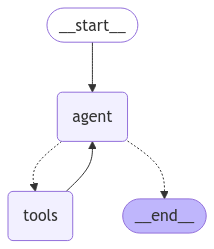

In [55]:
import json
from typing import (
    Annotated,
    Sequence,
    TypedDict,
    List,
)

from pydantic import BaseModel, Field

# LangChain / LangGraph imports
from langchain_core.messages import (
    SystemMessage,
    AIMessage,
    HumanMessage,
    BaseMessage,
    ToolMessage,
)
from langchain_core.tools import StructuredTool
from langchain_core.runnables import RunnableConfig

from langgraph.prebuilt import InjectedStore
from langgraph.store.base import BaseStore
from langgraph.store.memory import InMemoryStore
from langgraph.checkpoint.memory import MemorySaver
from langchain.embeddings import init_embeddings
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

###############################################################################
# 1. Initialize memory + config
###############################################################################
in_memory_store = InMemoryStore(
    index={
        "embed": init_embeddings("huggingface:sentence-transformers/all-MiniLM-L6-v2"),
        "dims": 384,  # Embedding dimensions
    }
)

# A memory saver to checkpoint conversation states
checkpointer = MemorySaver()

# Initialize config with user & thread info
config = {}
config["configurable"] = {
    "user_id": "user_1",
    "thread_id": 0,
}

###############################################################################
# 2. Define MessagesState
###############################################################################
class MessagesState(TypedDict):
    """The state of the agent.

    The key 'messages' uses add_messages as a reducer,
    so each time this state is updated, new messages are appended.
    # See https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers
    """
    messages: Annotated[Sequence[BaseMessage], add_messages]


###############################################################################
# 3. Memory Tools
###############################################################################
def save_memory(summary_text: str, *, config: RunnableConfig, store: BaseStore) -> str:
    """Save the given memory for the current user and return the key."""
    user_id = config.get("configurable", {}).get("user_id")
    thread_id = config.get("configurable", {}).get("thread_id")
    namespace = (user_id, "memories")
    memory_id = thread_id
    store.put(namespace, memory_id, {"memory": summary_text})
    return f"Saved to memory key: {memory_id}"

def update_memory(state: MessagesState, config: RunnableConfig, *, store: BaseStore):
    # Extract the messages list from the event, handling potential missing key
    messages = state["messages"]
    # Convert LangChain messages to dictionaries before storing
    messages_dict = [{"role": msg.type, "content": msg.content} for msg in messages]

    # Get the user id from the config
    user_id = config.get("configurable", {}).get("user_id")
    thread_id = config.get("configurable", {}).get("thread_id")
    # Namespace the memory
    namespace = (user_id, "memories")
    # Create a new memory ID
    memory_id = f"{thread_id}"
    store.put(namespace, memory_id, {"memory": messages_dict})
    return f"Saved to memory key: {memory_id}"


# Define a Pydantic schema for the save_memory tool (if needed elsewhere)
# https://langchain-ai.github.io/langgraphjs/reference/classes/checkpoint.InMemoryStore.html
class RecallMemory(BaseModel):
    query_text: str = Field(..., title="Search Text", description="The text to search from memories for similar records.")
    k: int = Field(5, title="Number of Results", description="Number of results to retrieve.")

def recall_memory(query_text: str, k: int = 5) -> str:
    """Retrieve user memories from in_memory_store."""
    user_id = config.get("configurable", {}).get("user_id")
    memories = [
        m.value["memory"] for m in in_memory_store.search((user_id, "memories"), query=query_text, limit=k)
        if "memory" in m.value
    ]
    return f"User memories: {memories}"

# Create a StructuredTool from the function
recall_memory_tool = StructuredTool.from_function(
    func=recall_memory,
    name="Recall Memory Tool",
    description="""
      Retrieve memories relevant to the user's query.
      """,
    args_schema=RecallMemory,
    response_format="content",
    return_direct=False,
    verbose=False
)

###############################################################################
# 4. Summarize Node (using StructuredTool)
###############################################################################
# Define a Pydantic schema for the Summary tool
class SummariseConversation(BaseModel):
    summary_text: str = Field(..., title="text", description="Write a summary of entire conversation here")

def summarise_node(summary_text: str):
    """
    Final node that summarizes the entire conversation for the current thread,
    saves it in memory, increments the thread_id, and ends the conversation.
    Returns a confirmation string.
    """
    user_id = config["configurable"]["user_id"]
    current_thread_id = config["configurable"]["thread_id"]
    new_thread_id = str(int(current_thread_id) + 1)

    # Prepare configuration for saving memory with updated thread id
    config_for_saving = {
        "configurable": {
            "user_id": user_id,
            "thread_id": new_thread_id
        }
    }
    key = save_memory(summary_text, config=config_for_saving, store=in_memory_store)
    #return f"Summary saved under key: {key}"

# Create a StructuredTool from the function (this wraps summarise_node)
summarise_tool = StructuredTool.from_function(
    func=summarise_node,
    name="Summary Tool",
    description="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers so the next conversation thread can continue.
      Do not reveal solutions to the user yet. Use this tool to save
      the current conversation to memory and then end the conversation.
      """,
    args_schema=SummariseConversation,
    response_format="content",
    return_direct=False,
    verbose=True
)

def call_summary(state: MessagesState, config: RunnableConfig):
    # Convert message dicts to HumanMessage instances if needed.
    system_message="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers.
      """
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(AIMessage(content=system_message, role=m.get("role", "assistant")))
        else:
            messages.append(m)

    summaries = llm_with_tools.invoke(messages)

    summary_content = summaries.content

    # Call Tool Manually
    message_with_single_tool_call = AIMessage(
        content="",
        tool_calls=[
            {
                "name": "Summary Tool",
                "args": {"summary_text": summary_content},
                "id": "tool_call_id",
                "type": "tool_call",
            }
        ],
    )

    tool_node.invoke({"messages": [message_with_single_tool_call]})


###############################################################################
# 5. Build the Graph
###############################################################################
graph_builder = StateGraph(MessagesState)

# Use the built-in ToolNode from langgraph that calls any declared tools.
tools = [
    mcq_retriever_tool,
    web_extraction_tool,
    ensemble_retriever_tool,
    general_retriever_tool,
    in_memory_retriever_tool,
    recall_memory_tool,
    summarise_tool,
]

tool_node = ToolNode(tools=tools)
#end_node = ToolNode(tools=[summarise_tool])

# Wrap your model with tools
llm_with_tools = model.bind_tools(tools)

###############################################################################
# 6. The agent's main node: call_model
###############################################################################
def call_model(state: MessagesState, config: RunnableConfig):
    """
    The main agent node that calls the LLM with the user + system messages.
    Since our vLLM chat wrapper expects a list of BaseMessage objects,
    we convert any dict messages to HumanMessage objects.
    If the LLM requests a tool call, we'll route to the 'tools' node next
    (depending on the condition).
    """
    # Convert message dicts to HumanMessage instances if needed.
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(HumanMessage(content=m.get("content", ""), role=m.get("role", "user")))
        else:
            messages.append(m)

    # Invoke the LLM (with tools) using the converted messages.
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]}



def call_summary(state: MessagesState, config: RunnableConfig):
    # Convert message dicts to HumanMessage instances if needed.
    system_message="""
      Summarize the current conversation in no more than
      1000 words. Also retain any unanswered quiz questions along with
      your internal answers.
      """
    messages = []
    for m in state["messages"]:
        if isinstance(m, dict):
            # Use role from dict (defaulting to 'user' if missing)
            messages.append(AIMessage(content=system_message, role=m.get("role", "assistant")))
        else:
            messages.append(m)

    summaries = llm_with_tools.invoke(messages)

    summary_content = summaries.content

    # Call Tool Manually
    message_with_single_tool_call = AIMessage(
        content="",
        tool_calls=[
            {
                "name": "Summary Tool",
                "args": {"summary_text": summary_content},
                "id": "tool_call_id",
                "type": "tool_call",
            }
        ],
    )

    tool_node.invoke({"messages": [message_with_single_tool_call]})

###############################################################################
# 7. Add Nodes & Edges, Then Compile
###############################################################################
graph_builder.add_node("agent", call_model)
graph_builder.add_node("tools", tool_node)
#graph_builder.add_node("summary", call_summary)

# Entry point
graph_builder.set_entry_point("agent")

# def custom_tools_condition(llm_output: dict) -> str:
#     """Return which node to go to next based on the LLM output."""

#     # The LLM's JSON might have a field like {"name": "Recall Memory Tool", "arguments": {...}}.
#     tool_name = llm_output.get("name", None)

#     # If the LLM calls "Summary Tool", jump directly to the 'summary' node
#     if tool_name == "Summary Tool":
#         return "summary"

#     # If the LLM calls any other recognized tool, go to 'tools'
#     valid_tool_names = [t.name for t in tools]  # all tools in the main tool_node
#     if tool_name in valid_tool_names:
#         return "tools"

#     # If there's no recognized tool name, assume we're done => go to summary
#     return "__end__"

# graph_builder.add_conditional_edges(
#     "agent",
#     custom_tools_condition,
#     {
#         "tools": "tools",
#         "summary": "summary",
#         "__end__": "summary",
#     }
# )

# If LLM requests a tool, go to "tools", otherwise go to "summary"
graph_builder.add_conditional_edges("agent", tools_condition)
#graph_builder.add_conditional_edges("agent", tools_condition, {"tools": "tools", "__end__": "summary"})
#graph_builder.add_conditional_edges("agent", lambda llm_output: "tools" if llm_output.get("name", None) in [t.name for t in tools] else "summary", {"tools": "tools", "__end__": "summary"}

# If we used a tool, return to the agent for final answer or more tools
graph_builder.add_edge("tools", "agent")
#graph_builder.add_edge("agent", "summary")
#graph_builder.set_finish_point("summary")

# Compile the graph with checkpointing and persistent store
graph = graph_builder.compile(checkpointer=checkpointer, store=in_memory_store)

#from langgraph.prebuilt import create_react_agent
#graph = create_react_agent(llm_with_tools, tools=tool_node, checkpointer=checkpointer, store=in_memory_store)

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


### Testing on Tool Calling

In [76]:
# Test to Call Tool Manually
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "Assistant References Retrieval Tool",
            "args": {"input": "Deep Learning"},
            "id": "tool_call_id",
            "type": "tool_call",
        }
    ],
)

tool_node.invoke({"messages": [message_with_single_tool_call]})

{'messages': [ToolMessage(content='["Deep Learning\\na machine learning technique in which layers of neural networks are used to process data and make decisions", "Fundamentals of Deep Learning\\nPart 5: Pre-trained Models\\n•, 1 = Part 1:  An Introduction to Deep Learning. •, 1 = Part 2: How a Neural Network Trains. •, 1 = Part 3: Convolutional Neural Networks. •, 1 = Part 4: Data Augmentation and Deployment. •, 1 = Part 5: Pre-Trained Models. •, 1 = Part 6: Advanced Architectures\\nAgenda\\nReview So Far", "overcome as the concept of neural network was introduced in AI. After that machine learning is\\nrevolutionized completely. Deep learning techniques are based on the concept of neural network; provide\\namazing results in all fields. In this paper we discussed deep learning, various techniques of deep learning.\\nIn the first section of paper introduction is given. In second section of the paper deep learning and its\\nworking is described. In next section various deep learning te

In [77]:
# Replacing the JSON with Tool calls
llm_with_tools.invoke(question_1).tool_calls

[{'name': 'Web Extraction Tool',
  'args': {'input': 'Deep Learning',
   'k': 5,
   'url': 'https://www.ibm.com/think/topics/artificial-intelligence, https://www.ibm.com/think/topics/machine-learning'},
  'id': 'call_n7dm',
  'type': 'tool_call'}]

In [78]:
# Test to Call Tool Manually
tool_call_msg = AIMessage(
    content="",
    tool_calls=llm_with_tools.invoke(question_2).tool_calls,
)

tool_result = tool_node.invoke({"messages": [tool_call_msg]})
tool_result

{'messages': [ToolMessage(content='{"./Documents/mcq/mcq.csv_Qn2 mcq_question": "Your organization is developing a decision support solution to monitor data for anomalies and deliver real-time insights to stakeholders. The solution requires continuous monitoring and automated alerts for deviations from expected patterns. Which Azure AI service should you select to implement the data monitoring aspect effectively?", "./Documents/mcq/mcq.csv_Qn2 mcq_answer": "Answer - [A] Azure AI Metrics Advisor", "./Documents/mcq/mcq.csv_Qn2 mcq_answer_reason": "Option A - Azure AI Metrics Advisor: Specifically designed for real-time anomaly detection and continuous data monitoring, making it the best fit for the given scenario.|EXAM FOCUS - Always remember to use Azure AI Metrics Advisor for real-time data monitoring and anomaly detection. Make sure the solution is set up to continuously monitor data streams to detect deviations early.|CAUTION ALERT - Stay alert to not mistakenly select services like 

### Test Questions

In [61]:
# URL
url1 = "https://www.ibm.com/think/topics/artificial-intelligence"
url2 = "https://www.ibm.com/think/topics/machine-learning"

question_1 = (f"Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: {url1} and {url2} to provide the context")
question_2 = "Provide 5 MCQ questions on Artificial Intelligence to help me with practice."
question_3 = "Here are my answers: 1. A, 2. B, 3. C, 4. D, 5. E. Please check mu answer, provide reasons for my wrong answers and provide the correct answers with explanations."
question_4 = "Provide another 5 MCQ questions on Artificial Intelligence to help me with practice."
question_5 = "Here are my answers: 1. A, 2. B, 3. C, 4. D, 5. E. Please check mu answer, provide reasons for my wrong answers and provide the correct answers with explanations."
question_6 = "Provide a study quide to help me learn for my wrong answers for the MCQ questions."
question_7 = "Based on your reference databases only, provide a study quide on Deep Learning."
question_8 = "Based on your memory, provide a summary of our conversation."
question_9 = "Summarise the conversation so far."


# Grab the current user_id and thread_id from config
user_id = "user_1"

# Get last thread_id
last_thread_id = config["configurable"]["thread_id"]
thread_id = str(int(last_thread_id) + 1)

# Print Config
print(f"Conversation Thread ID: {last_thread_id} -> {thread_id}")

# Update the config with the new thread_id
config = {"configurable": {"thread_id": thread_id, "user_id": user_id}}

# Create a system prompt (your overall instructions to the AI)
system_prompt = (f"""
You are a helpful AI Tutor assistant.
""")

#The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [
        #{"role": "system", "content": system_prompt},
        {"role": "user", "content": question_1}]},
    config, # Pass the thread-level persistence to the graph
    stream_mode="values",
)
for event in events:
    response = event["messages"][-1]
    response.pretty_print()

update_memory(event, config, store=in_memory_store) # Update Memory

Conversation Thread ID: 2 -> 3
================================ Human Message =================================

Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: https://www.ibm.com/think/topics/artificial-intelligence and https://www.ibm.com/think/topics/machine-learning to provide the context
================================== Ai Message ==================================
Tool Calls:
  Web Extraction Tool (call_d6c2)
 Call ID: call_d6c2
  Args:
    input: What is Deep Learning?
    url: https://www.ibm.com/think/topics/artificial-intelligence, https://www.ibm.com/think/topics/machine-learning
    k: 5
================================= Tool Message =================================
Name: Web Extraction Tool

["like humans, explore its history and the types of AI, and uncover the ways it impacts our lives.     What is machine learning?   Gain insight into how ML leverages data and algorithms, its use cases and associated concerns to empower r

'Saved to memory key: 3'

In [65]:
# Function for user to input their query and system prompt to the agent
def submit_query(user_query, system_prompt, temperature, config: RunnableConfig):
    """
    Triggered when the user clicks the submit icon.
    - user_query -> str
    - system_prompt -> str
    - temperature -> float
    """
    # 'user_1' from the config in utils.
    USER_ID = config["configurable"]["user_id"]
    # Get last thread_id
    last_thread_id = config["configurable"]["thread_id"]
    thread_id = str(int(last_thread_id) + 1)

    # Update the config with the new thread_id
    config = {"configurable": {"thread_id": thread_id, "user_id": USER_ID}}

    # 1) Call query_agent as before to get the streaming generator.
    events = graph.stream(
        {
            "messages": [
                #{"role": "system", "content": system_prompt},
                {"role": "user", "content": user_query}
            ]
        },
        config,  # user_id, thread_id, etc.
        stream_mode="values",
    )

    # 2) We'll capture each message's pretty_print() into a list for the console.
    from io import StringIO
    import sys

    message_stream = []
    final_response = ""
    for event in events:
        # Each event is a dict with "messages" as a list of BaseMessage objects.
        for msg in event["messages"]:
            # If for some reason the msg doesn't support pretty_print, we fallback to .content
            captured_output = StringIO()
            original_stdout = sys.stdout
            try:
                sys.stdout = captured_output
                # If it's an AI/Tool message with pretty_print(), call it:
                if hasattr(msg, "pretty_print"):
                    msg.pretty_print()
                else:
                    # Otherwise, just print its content
                    print(msg.content)
            finally:
                sys.stdout = original_stdout

            # Store the captured text into our message_stream
            pretty_text = captured_output.getvalue()
            message_stream.append(pretty_text.strip())

        # If this event had at least one message, the last is presumably the LLM's response
        if event["messages"]:
            final_response = event["messages"][-1].content

    update_memory(event, config, store=in_memory_store) # Update Memory

    # 3) Return final response for the chatbot's main window
    #    and the entire stream for the console output.
    return final_response, "\n".join(message_stream), config


In [66]:
# Test the query function
submit_query(question_2, system_msg.content, 0.2, config)

('',
 '================================\x1b Human Message \x1b=================================\n\nProvide 5 MCQ questions on Artificial Intelligence to help me with practice.\n================================\x1b Human Message \x1b=================================\n\nProvide 5 MCQ questions on Artificial Intelligence to help me with practice.\n==================================\x1b Ai Message \x1b==================================\nTool Calls:\n  MCQ Retrieval Tool (call_ej87)\n Call ID: call_ej87\n  Args:\n    input: Artificial Intelligence\n    k: 5\n================================\x1b Human Message \x1b=================================\n\nProvide 5 MCQ questions on Artificial Intelligence to help me with practice.\n==================================\x1b Ai Message \x1b==================================\nTool Calls:\n  MCQ Retrieval Tool (call_ej87)\n Call ID: call_ej87\n  Args:\n    input: Artificial Intelligence\n    k: 5\n=================================\x1b Tool Message \x1b==

### Accessing and Testing LLM Chat Model Memory Persistence

In [67]:
# List out the saved memory
saved_memory = in_memory_store.list_namespaces()
print("List of memory saved: "+ str(saved_memory))

# Print out all memory saved
for m in saved_memory:
  print(in_memory_store.search(m))


List of memory saved: [('user_1', 'memories')]
[Item(namespace=['user_1', 'memories'], key='1', value={'memory': [{'role': 'human', 'content': 'Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: https://www.ibm.com/think/topics/artificial-intelligence and https://www.ibm.com/think/topics/machine-learning to provide the context'}, {'role': 'ai', 'content': ''}, {'role': 'tool', 'content': '["like humans, explore its history and the types of AI, and uncover the ways it impacts our lives.     What is machine learning?   Gain insight into how ML leverages data and algorithms, its use cases and associated concerns to empower responsible and innovative use of the technology.    What is deep learning?   Discover how deep learning simulates our brain, helping systems learn to identify and perform complex tasks with increasing accuracy unsupervised.    What is the k-nearest neighbors algorithm?   Learn about the k-nearest neighbors algorithm, one of the

In [68]:
user_id = "user_1"
namespace_for_memory = (user_id, "memories")
memories = in_memory_store.search(namespace_for_memory)

for i in range(len(memories)):
  print(memories[i].dict())

{'namespace': ['user_1', 'memories'], 'key': '1', 'value': {'memory': [{'role': 'human', 'content': 'Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: https://www.ibm.com/think/topics/artificial-intelligence and https://www.ibm.com/think/topics/machine-learning to provide the context'}, {'role': 'ai', 'content': ''}, {'role': 'tool', 'content': '["like humans, explore its history and the types of AI, and uncover the ways it impacts our lives.     What is machine learning?   Gain insight into how ML leverages data and algorithms, its use cases and associated concerns to empower responsible and innovative use of the technology.    What is deep learning?   Discover how deep learning simulates our brain, helping systems learn to identify and perform complex tasks with increasing accuracy unsupervised.    What is the k-nearest neighbors algorithm?   Learn about the k-nearest neighbors algorithm, one of the popular and simplest classification and re

In [69]:
recall=memories = [m.value["memory"] for m in in_memory_store.search(("user_1", "memories"), query="Deep Learning", limit=5)]
print(recall)

[[{'role': 'human', 'content': 'Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: https://www.ibm.com/think/topics/artificial-intelligence and https://www.ibm.com/think/topics/machine-learning to provide the context'}, {'role': 'ai', 'content': ''}, {'role': 'tool', 'content': '["like humans, explore its history and the types of AI, and uncover the ways it impacts our lives.     What is machine learning?   Gain insight into how ML leverages data and algorithms, its use cases and associated concerns to empower responsible and innovative use of the technology.    What is deep learning?   Discover how deep learning simulates our brain, helping systems learn to identify and perform complex tasks with increasing accuracy unsupervised.    What is the k-nearest neighbors algorithm?   Learn about the k-nearest neighbors algorithm, one of the popular and simplest classification and regression classifiers used in machine learning today.     What is natu

In [71]:
in_memory_store.search(("user_1", "memories"), query="Deep Learning", limit=1)

[Item(namespace=['user_1', 'memories'], key='1', value={'memory': [{'role': 'human', 'content': 'Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: https://www.ibm.com/think/topics/artificial-intelligence and https://www.ibm.com/think/topics/machine-learning to provide the context'}, {'role': 'ai', 'content': ''}, {'role': 'tool', 'content': '["like humans, explore its history and the types of AI, and uncover the ways it impacts our lives.     What is machine learning?   Gain insight into how ML leverages data and algorithms, its use cases and associated concerns to empower responsible and innovative use of the technology.    What is deep learning?   Discover how deep learning simulates our brain, helping systems learn to identify and perform complex tasks with increasing accuracy unsupervised.    What is the k-nearest neighbors algorithm?   Learn about the k-nearest neighbors algorithm, one of the popular and simplest classification and regres

In [72]:
print_recall = in_memory_store.get(("user_1", "memories"), "1")
print(print_recall)

Item(namespace=['user_1', 'memories'], key='1', value={'memory': [{'role': 'human', 'content': 'Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: https://www.ibm.com/think/topics/artificial-intelligence and https://www.ibm.com/think/topics/machine-learning to provide the context'}, {'role': 'ai', 'content': ''}, {'role': 'tool', 'content': '["like humans, explore its history and the types of AI, and uncover the ways it impacts our lives.     What is machine learning?   Gain insight into how ML leverages data and algorithms, its use cases and associated concerns to empower responsible and innovative use of the technology.    What is deep learning?   Discover how deep learning simulates our brain, helping systems learn to identify and perform complex tasks with increasing accuracy unsupervised.    What is the k-nearest neighbors algorithm?   Learn about the k-nearest neighbors algorithm, one of the popular and simplest classification and regress

In [75]:
# Define function to download the entire conversation history from the memory store and save it to a file
def download_conversation_history(user_id: str, store: BaseStore = in_memory_store) -> str:
    """
    Download the entire conversation history from memory store and save it to a JSON file.
    """
    memories = store.search((user_id, "memories"))
    conversation_history = [m.value.get("memory") for m in memories if "memory" in m.value]
    filename = f"{user_id}_conversation_history.json"
    with open(filename, "w") as f:
        json.dump(conversation_history, f, indent=2)
    return f"Conversation history saved to {filename}"

# Download the conversation history
download_conversation_history(user_id, in_memory_store)

# Print the conversation history
with open(f"{user_id}_conversation_history.json", "r") as f:
    conversation_history = json.load(f)
    print("Conversation History:")
    print(json.dumps(conversation_history, indent=2))

Conversation History:
[
  [
    {
      "role": "human",
      "content": "Find out about Deep Learning from databases. Using Web Extraction Tool, search from website: https://www.ibm.com/think/topics/artificial-intelligence and https://www.ibm.com/think/topics/machine-learning to provide the context"
    },
    {
      "role": "ai",
      "content": ""
    },
    {
      "role": "tool",
      "content": "[\"like humans, explore its history and the types of AI, and uncover the ways it impacts our lives.     What is machine learning?   Gain insight into how ML leverages data and algorithms, its use cases and associated concerns to empower responsible and innovative use of the technology.    What is deep learning?   Discover how deep learning simulates our brain, helping systems learn to identify and perform complex tasks with increasing accuracy unsupervised.    What is the k-nearest neighbors algorithm?   Learn about the k-nearest neighbors algorithm, one of the popular and simplest cl